# Capstone Project: Create a Customer Segmentation Report for Arvato Financial Services

In this project, you will analyze demographics data for customers of a mail-order sales company in Germany, comparing it against demographics information for the general population. You'll use unsupervised learning techniques to perform customer segmentation, identifying the parts of the population that best describe the core customer base of the company. Then, you'll apply what you've learned on a third dataset with demographics information for targets of a marketing campaign for the company, and use a model to predict which individuals are most likely to convert into becoming customers for the company. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

If you completed the first term of this program, you will be familiar with the first part of this project, from the unsupervised learning project. The versions of those two datasets used in this project will include many more features and has not been pre-cleaned. You are also free to choose whatever approach you'd like to analyzing the data rather than follow pre-determined steps. In your work on this project, make sure that you carefully document your steps and decisions, since your main deliverable for this project will be a blog post reporting your findings.

## README
Thank you for looking into my project. <font color='red'>Please note</font>:
* If you are interested in the data exploration, you need to start from beginning on (inluding Segmentaiton Report).
* If you just want to run _PART II - Supervised Learning_, jump to [Assemble findings in functions for Pipelinining](#Assemble-findings-in-functions-for-Pipelinining) and execute function from there on.
 * To run the Supervised Learning & Prediction for Kaggle you need to have installed h2o along with an JRE (not newer than JRE 13) and a bit of RAM - in my case 20GB were enough

In [ ]:
!pip install h2o

In [ ]:
!pip install kneebow

In [99]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# ML libraries
from scipy import stats
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

import h2o
from kneebow.rotor import Rotor
import pickle

# magic word for producing visualizations in notebook
%matplotlib inline

## Custom functions

In [2]:
def missing_observation(df):
    '''
    INPUT:
    df - (Pandas DataFrame) Data set which should be tested on missing row-wise
    
    OUTPUT:
    share_missings - (list) ratios of missing values per rows
    
    '''
    
    share_missing = []
    
    for i in range(10, 110, 10):
        c_share_missings = df[df.isnull().mean(axis=1).reset_index(name='missing_ratio')['missing_ratio'] > i/100].shape[0]
        share_missing.append(c_share_missings)
        
        print('For the ratio {}% missings of columns per observation there are {} ({}%) observations.'.format(i, c_share_missings, round(c_share_missings/df.shape[0]*100)))
    
    return share_missing

def rchop(s, suffix):
    '''
    INPUT:
    s - (string) string value which will be chopped
    suffix - (string) Suffix
    
    OUTPUT:
    s - (string) Manipulated string
    
    '''
    if suffix and s.endswith(suffix):
        return s[:-len(suffix)]
    return s


def missing_imputation_kind4(df):
    '''
    INPUT:
    df - (Pandas DataFrame) input data set

    OUTPUT:
    df_pca - (Pandas DataFrame) Manipulated data frame
    
    '''
    print('>> Starting imputation logic for feature "ALTER_KIND4" on dataframe')
    idx = df[(df['ANZ_KINDER'] >= 4) & (df['ALTER_KIND4'].isnull())][['ANZ_KINDER', 'ALTER_KIND4']].index.tolist()
    print('\tbefore imputation, there are {} missing observations.'.format(len(idx)))

    dict_imputation = {}
    for i in idx:
        ages = []
        ages_dist = []
        ages = [int(x) for x in df.loc[i][['ALTER_KIND1', 'ALTER_KIND2', 'ALTER_KIND3']].tolist() if str(x) != 'nan']

        if len(ages) > 1:
            if len(ages) == 3:
                ages_dist.append(ages[2] - ages[1])
            if len(ages) >= 2:
                ages_dist.append(ages[1] - ages[0])

            #print('index:', i)
            #print('ages:', ages)
            #print('ages_dist:', ages_dist)
            imputed_age = max(ages) + (sum(ages_dist) / len(ages_dist))

            dict_imputation.update({i: imputed_age})

    # Apply the extracted imputing values on DataFrame
    for key, val in dict_imputation.items():
        df.loc[key, 'ALTER_KIND4'] = val

    idx = df[(df['ANZ_KINDER'] >= 4) & (df['ALTER_KIND4'].isnull())][['ANZ_KINDER', 'ALTER_KIND4']].index.tolist()
    print('\tafter imputation, there are {} missing observations remaining.'.format(len(idx)))

    return df

def missing_imputation_kind3(df):
    '''
    INPUT:
    df - (Pandas DataFrame) input data set

    OUTPUT:
    df_pca - (Pandas DataFrame) Manipulated data frame
    
    '''
    print('>> Starting imputation logic for feature "ALTER_KIND3" on dataframe')
    idx = df[(df['ANZ_KINDER'] >= 3) & (df['ALTER_KIND3'].isnull())][['ANZ_KINDER', 'ALTER_KIND3']].index.tolist()
    print('\tbefore imputation, there are {} missing observations.'.format(len(idx)))

    dict_imputation = {}
    for i in idx:
        ages = []
        ages_dist = []
        ages = [int(x) for x in df.loc[i][['ALTER_KIND1', 'ALTER_KIND2']].tolist() if str(x) != 'nan']

        if len(ages) > 1:
            if len(ages) == 2:
                ages_dist.append(ages[1] - ages[0])

            #print('index:', i)
            #print('ages:', ages)
            #print('ages_dist:', ages_dist)
            imputed_age = max(ages) + (sum(ages_dist) / len(ages_dist))

            dict_imputation.update({i: imputed_age})

    # Apply the extracted imputing values on DataFrame
    for key, val in dict_imputation.items():
        df.loc[key, 'ALTER_KIND3'] = val
    
    idx = df[(df['ANZ_KINDER'] >= 3) & (df['ALTER_KIND3'].isnull())][['ANZ_KINDER', 'ALTER_KIND3']].index.tolist()
    print('\tafter imputation, there are {} missing observations remaining.'.format(len(idx)))
    
    return df

_Jump directly to the implementation and skip the exploration_
[Jump to implementation](#Preprocessing-Pipeline)

## Part 0: Get to Know the Data

There are four data files associated with this project:

- `Udacity_AZDIAS_052018.csv`: Demographics data for the general population of Germany; 891 211 persons (rows) x 366 features (columns).
- `Udacity_CUSTOMERS_052018.csv`: Demographics data for customers of a mail-order company; 191 652 persons (rows) x 369 features (columns).
- `Udacity_MAILOUT_052018_TRAIN.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 982 persons (rows) x 367 (columns).
- `Udacity_MAILOUT_052018_TEST.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 833 persons (rows) x 366 (columns).

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. Use the information from the first two files to figure out how customers ("CUSTOMERS") are similar to or differ from the general population at large ("AZDIAS"), then use your analysis to make predictions on the other two files ("MAILOUT"), predicting which recipients are most likely to become a customer for the mail-order company.

The "CUSTOMERS" file contains three extra columns ('CUSTOMER_GROUP', 'ONLINE_PURCHASE', and 'PRODUCT_GROUP'), which provide broad information about the customers depicted in the file. The original "MAILOUT" file included one additional column, "RESPONSE", which indicated whether or not each recipient became a customer of the company. For the "TRAIN" subset, this column has been retained, but in the "TEST" subset it has been removed; it is against that withheld column that your final predictions will be assessed in the Kaggle competition.

Otherwise, all of the remaining columns are the same between the three data files. For more information about the columns depicted in the files, you can refer to two Excel spreadsheets provided in the workspace. [One of them](./DIAS Information Levels - Attributes 2017.xlsx) is a top-level list of attributes and descriptions, organized by informational category. [The other](./DIAS Attributes - Values 2017.xlsx) is a detailed mapping of data values for each feature in alphabetical order.

In the below cell, we've provided some initial code to load in the first two datasets. Note for all of the `.csv` data files in this project that they're semicolon (`;`) delimited, so an additional argument in the [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call has been included to read in the data properly. Also, considering the size of the datasets, it may take some time for them to load completely.

You'll notice when the data is loaded in that a warning message will immediately pop up. Before you really start digging into the modeling and analysis, you're going to need to perform some cleaning. Take some time to browse the structure of the data and look over the informational spreadsheets to understand the data values. Make some decisions on which features to keep, which features to drop, and if any revisions need to be made on data formats. It'll be a good idea to create a function with pre-processing steps, since you'll need to clean all of the datasets before you work with them.

## Load data sets

In [3]:
# load in the data
#azdias = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_AZDIAS_052018.csv', sep=';') # data path on Udacity workspace environment
#customers = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_CUSTOMERS_052018.csv', sep=';') # data path on Udacity workspace environment
azdias = pd.read_csv('arvato_data/Udacity_AZDIAS_052018.csv', sep=';') # data path on local workspace environment
customers = pd.read_csv('arvato_data/Udacity_CUSTOMERS_052018.csv', sep=';') # data path on local workspace environment

C:\Users\spam\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3072: DtypeWarning: Columns (18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


### Importing data description files

In [4]:
# Import azdias description file
desc_azdias = pd.read_excel('DIAS Attributes - Values 2017.xlsx', skiprows=1).drop('Unnamed: 0', axis=1)

desc_azdias.fillna(method='ffill', inplace=True) # fix the Excel writing style for a better reading style in Pandas
desc_azdias['Type'] = desc_azdias['Meaning'].apply(lambda x: 'ordinal' if 'coded' in x.lower() else ('continuous' if 'numeric' in x.lower() else 'categorical'))

# Prepare as usable Pandas DataFrame
desc_azdias = desc_azdias.merge(desc_azdias[desc_azdias['Meaning'].str.lower() == 'unknown'][['Attribute', 'Value']].rename({'Value':'Missing_Value'}, axis=1), on='Attribute', how='left').groupby(['Attribute']).agg(Description=('Description','first'), Type=('Type','first'), Unknown_Indicator=('Missing_Value','first')).reset_index()

desc_azdias.head()

,Attribute,Description,Type,Unknown_Indicator
0,AGER_TYP,best-ager typology,categorical,-1
1,ALTERSKATEGORIE_GROB,age classification through prename analysis,categorical,"-1, 0"
2,ALTER_HH,main age within the household,categorical,NaN
3,ANREDE_KZ,gender,categorical,"-1, 0"
4,ANZ_HAUSHALTE_AKTIV,number of households in the building,ordinal,NaN


In [5]:
# Types of attributes
desc_azdias.groupby(['Type']).agg(cnt_attributes=('Attribute','count')).reset_index()

,Type,cnt_attributes
0,categorical,307
1,continuous,3
2,ordinal,4


In [6]:
# Import azdias levels file
desc_azdias_levels = pd.read_excel('DIAS Information Levels - Attributes 2017.xlsx', skiprows=1).drop('Unnamed: 0', axis=1)
t_informationlevels = desc_azdias_levels['Information level'].unique().tolist()

# Clean up the messed up Excel file
cols_sel = ['AGER_TYP', 'ALTERSKATEGORIE_GROB', 'ANREDE_KZ', 'CJT_GESAMTTYP', 'FINANZ_MINIMALIST', 'FINANZ_SPARER', 'FINANZ_VORSORGER', 'FINANZ_ANLEGER', 'FINANZ_UNAUFFAELLIGER', 'FINANZ_HAUSBAUER', 'FINANZTYP', 'GEBURTSJAHR', 'GFK_URLAUBERTYP', 'GREEN_AVANTGARDE', 'HEALTH_TYP', 'LP_LEBENSPHASE_FEIN', 'LP_LEBENSPHASE_GROB', 'LP_FAMILIE_FEIN', 'LP_FAMILIE_GROB', 'LP_STATUS_FEIN', 'LP_STATUS_GROB', 'NATIONALITAET_KZ', 'PRAEGENDE_JUGENDJAHRE', 'RETOURTYP_BK_S', 'SEMIO_SOZ', 'SEMIO_FAM', 'SEMIO_REL', 'SEMIO_MAT', 'SEMIO_VERT', 'SEMIO_LUST', 'SEMIO_ERL', 'SEMIO_KULT', 'SEMIO_RAT', 'SEMIO_KRIT', 'SEMIO_DOM', 'SEMIO_KAEM', 'SEMIO_PFLICHT', 'SEMIO_TRADV', 'SHOPPER_TYP', 'SOHO_FLAG', 'TITEL_KZ', 'VERS_TYP', 'ZABEOTYP']
desc_azdias_levels.loc[desc_azdias_levels['Attribute'].isin(cols_sel), 'Information level'] = t_informationlevels[1] # Person

cols_sel = ['ALTER_HH', 'ANZ_PERSONEN', 'ANZ_TITEL', 'HAUSHALTSSTRUKTUR', 'HH_EINKOMMEN_SCORE', 'D19_KK_KUNDENTYP', 'D19_KONSUMTYP', 'D19_GESAMT_ANZ_12', 'D19_GESAMT_ANZ_24', 'D19_BANKEN_ ANZ_12', 'D19_BANKEN_ ANZ_24', 'D19_TELKO_ ANZ_12', 'D19_TELKO_ ANZ_24', 'D19_VERSI_ ANZ_12', 'D19_VERSI_ ANZ_24', 'D19_VERSAND_ ANZ_12', 'D19_VERSAND_ ANZ_24', 'D19_GESAMT_OFFLINE_DATUM', 'D19_GESAMT_ONLINE_DATUM', 'D19_GESAMT_DATUM', 'D19_BANKEN_OFFLINE_DATUM', 'D19_BANKEN_ONLINE_DATUM', 'D19_BANKEN_DATUM', 'D19_TELKO_OFFLINE_DATUM', 'D19_TELKO_ONLINE_DATUM', 'D19_TELKO_DATUM', 'D19_VERSAND_OFFLINE_DATUM', 'D19_VERSAND_ONLINE_DATUM', 'D19_VERSAND_DATUM', 'D19_VERSI_OFFLINE_DATUM', 'D19_VERSI_ONLINE_DATUM', 'D19_VERSI_DATUM', 'D19_GESAMT_ONLINE_QUOTE_12', 'D19_BANKEN_ONLINE_QUOTE_12', 'D19_VERSAND_ONLINE_QUOTE_12', 'W_KEIT_KIND_HH', 'WOHNDAUER_2008']
desc_azdias_levels.loc[desc_azdias_levels['Attribute'].isin(cols_sel), 'Information level'] = t_informationlevels[2] # Household

cols_sel = ['ANZ_HAUSHALTE_AKTIV', 'ANZ_HH_TITEL', 'GEBAEUDETYP', 'GEOSCORE_KLS7', 'KBA05_HERSTTEMP', 'KBA05_MODTEMP', 'KONSUMNAEHE', 'MIN_GEBAEUDEJAHR', 'OST_WEST_KZ', 'WOHNLAGE']
desc_azdias_levels.loc[desc_azdias_levels['Attribute'].isin(cols_sel), 'Information level'] = t_informationlevels[3] # Building

cols_sel = ['CAMEO_DEUG_2015', 'CAMEO_DEU_2015', 'CAMEO_DEUINTL_2015']
desc_azdias_levels.loc[desc_azdias_levels['Attribute'].isin(cols_sel), 'Information level'] = t_informationlevels[4] # Microcell (RR4_ID)

cols_sel = ['KBA05_ALTER1', 'KBA05_ALTER2', 'KBA05_ALTER3', 'KBA05_ALTER4', 'KBA05_ANHANG', 'KBA05_ANTG1', 'KBA05_ANTG2', 'KBA05_ANTG3', 'KBA05_ANTG4', 'KBA05_AUTOQUOT', 'KBA05_BAUMAX', 'KBA05_CCM1', 'KBA05_CCM2', 'KBA05_CCM3', 'KBA05_CCM4', 'KBA05_DIESEL', 'KBA05_FRAU', 'KBA05_GBZ', 'KBA05_HERST1', 'KBA05_HERST2', 'KBA05_HERST3', 'KBA05_HERST4', 'KBA05_HERST5', 'KBA05_KRSAQUOT', 'KBA05_KRSHERST1', 'KBA05_KRSHERST2', 'KBA05_KRSHERST3', 'KBA05_KRSKLEIN', 'KBA05_KRSOBER', 'KBA05_KRSVAN', 'KBA05_KRSZUL', 'KBA05_KW1', 'KBA05_KW2', 'KBA05_KW3', 'KBA05_MAXAH', 'KBA05_MAXBJ', 'KBA05_MAXHERST', 'KBA05_MAXSEG', 'KBA05_MAXVORB', 'KBA05_MOD1', 'KBA05_MOD2', 'KBA05_MOD3', 'KBA05_MOD4', 'KBA05_MOD8', 'KBA05_MOTOR', 'KBA05_MOTRAD', 'KBA05_SEG1', 'KBA05_SEG2', 'KBA05_SEG3', 'KBA05_SEG4', 'KBA05_SEG5', 'KBA05_SEG6', 'KBA05_SEG7', 'KBA05_SEG8', 'KBA05_SEG9', 'KBA05_SEG10', 'KBA05_VORB0', 'KBA05_VORB1', 'KBA05_VORB2', 'KBA05_ZUL1', 'KBA05_ZUL2', 'KBA05_ZUL3', 'KBA05_ZUL4', 'WACHSTUMSGEBIET_NB']
desc_azdias_levels.loc[desc_azdias_levels['Attribute'].isin(cols_sel), 'Information level'] = t_informationlevels[5] # Microcell (RR3_ID)
            
cols_sel = ['D19_BANKEN_DIREKT_RZ', 'D19_BANKEN_GROSS_RZ', 'D19_BANKEN_LOKAL_RZ', 'D19_BANKEN_REST_RZ', 'D19_BEKLEIDUNG_GEH_RZ', 'D19_BEKLEIDUNG_REST_RZ', 'D19_BIO_OEKO_RZ', 'D19_BILDUNG_RZ', 'D19_BUCH_RZ', 'D19_DIGIT_SERV_RZ', 'D19_DROGERIEARTIKEL_RZ', 'D19_ENERGIE_RZ', 'D19_FREIZEIT_RZ', 'D19_GARTEN_RZ', 'D19_HANDWERK_RZ', 'D19_HAUS_DEKO_RZ', 'D19_KINDERARTIKEL_RZ', 'D19_KOSMETIK_RZ', 'D19_LEBENSMITTEL_RZ', 'D19_NAHRUNGSERGAENZUNG_RZ', 'D19_RATGEBER_RZ', 'D19_REISEN_RZ', 'D19_SAMMELARTIKEL_RZ', 'D19_SCHUHE_RZ', 'D19_SONSTIGE_RZ', 'D19_TECHNIK_RZ', 'D19_TELKO_MOBILE_RZ', 'D19_TELKO_REST_RZ', 'D19_TIERARTIKEL_RZ', 'D19_VERSICHERUNGEN_RZ', 'D19_VOLLSORTIMENT_RZ', 'D19_VERSAND_REST_RZ', 'D19_WEIN_FEINKOST_RZ']
desc_azdias_levels.loc[desc_azdias_levels['Attribute'].isin(cols_sel), 'Information level'] = t_informationlevels[6] # 125m x 125m Grid

cols_sel = ['BALLRAUM', 'EWDICHTE', 'INNENSTADT', 'PLZ']
desc_azdias_levels.loc[desc_azdias_levels['Attribute'].isin(cols_sel), 'Information level'] = t_informationlevels[7] # Postcode


cols_sel = ['GEBAEUDETYP_RASTER', 'KKK', 'MOBI_REGIO', 'ONLINE_AFFINITAET', 'REGIOTYP']
desc_azdias_levels.loc[desc_azdias_levels['Attribute'].isin(cols_sel), 'Information level'] = t_informationlevels[8] # RR1_ID


cols_sel = ['KBA13_ALTERHALTER_30', 'KBA13_ALTERHALTER_45', 'KBA13_ALTERHALTER_60', 'KBA13_ALTERHALTER_61', 'KBA13_ANZAHL_PKW', 'KBA13_AUDI', 'KBA13_AUTOQUOTE', 'KBA13_BJ_1999', 'KBA13_BJ_2000', 'KBA13_BJ_2004', 'KBA13_BJ_2006', 'KBA13_BJ_2008', 'KBA13_BJ_2009', 'KBA13_BMW', 'KBA13_CCM_1000', 'KBA13_CCM_1200', 'KBA13_CCM_1400', 'KBA13_CCM_0_1400', 'KBA13_CCM_1500', 'KBA13_CCM_1400_2500', 'KBA13_CCM_1600', 'KBA13_CCM_1800', 'KBA13_CCM_2000', 'KBA13_CCM_2500', 'KBA13_CCM_2501', 'KBA13_FAB_ASIEN', 'KBA13_FAB_SONSTIGE', 'KBA13_FIAT', 'KBA13_FORD', 'KBA13_HALTER_20', 'KBA13_HALTER_25', 'KBA13_HALTER_30', 'KBA13_HALTER_35', 'KBA13_HALTER_40', 'KBA13_HALTER_45', 'KBA13_HALTER_50', 'KBA13_HALTER_55', 'KBA13_HALTER_60', 'KBA13_HALTER_65', 'KBA13_HALTER_66', 'KBA13_HERST_ASIEN', 'KBA13_HERST_AUDI_VW', 'KBA13_HERST_BMW_BENZ', 'KBA13_HERST_EUROPA', 'KBA13_HERST_FORD_OPEL', 'KBA13_HERST_SONST', 'KBA13_KMH_110', 'KBA13_KMH_140', 'KBA13_KMH_180', 'KBA13_KMH_0_140', 'KBA13_KMH_140_210', 'KBA13_KMH_211', 'KBA13_KMH_250', 'KBA13_KMH_251', 'KBA13_KRSAQUOT', 'KBA13_KRSHERST_AUDI_VW', 'KBA13_KRSHERST_BMW_BENZ', 'KBA13_KRSHERST_FORD_OPEL', 'KBA13_KRSSEG_KLEIN', 'KBA13_KRSSEG_OBER', 'KBA13_KRSSEG_VAN', 'KBA13_KRSZUL_NEU', 'KBA13_KW_30', 'KBA13_KW_40', 'KBA13_KW_50', 'KBA13_KW_60', 'KBA13_KW_0_60', 'KBA13_KW_70', 'KBA13_KW_61_120', 'KBA13_KW_80', 'KBA13_KW_90', 'KBA13_KW_110', 'KBA13_KW_120', 'KBA13_KW_121', 'KBA13_MAZDA', 'KBA13_MERCEDES', 'KBA13_MOTOR', 'KBA13_NISSAN', 'KBA13_OPEL', 'KBA13_PEUGEOT', 'KBA13_RENAULT', 'KBA13_SEG_GELAENDEWAGEN', 'KBA13_SEG_GROSSRAUMVANS', 'KBA13_SEG_KLEINST', 'KBA13_SEG_KLEINWAGEN', 'KBA13_SEG_KOMPAKTKLASSE', 'KBA13_SEG_MINIVANS', 'KBA13_SEG_MINIWAGEN', 'KBA13_SEG_MITTELKLASSE', 'KBA13_SEG_OBEREMITTELKLASSE', 'KBA13_SEG_OBERKLASSE', 'KBA13_SEG_SONSTIGE', 'KBA13_SEG_SPORTWAGEN', 'KBA13_SEG_UTILITIES', 'KBA13_SEG_VAN', 'KBA13_SEG_WOHNMOBILE', 'KBA13_SITZE_4', 'KBA13_SITZE_5', 'KBA13_SITZE_6', 'KBA13_TOYOTA', 'KBA13_VORB_0', 'KBA13_VORB_1', 'KBA13_VORB_1_2', 'KBA13_VORB_2', 'KBA13_VORB_3', 'KBA13_VW', 'PLZ8', 'PLZ8_ANTG1', 'PLZ8_ANTG2', 'PLZ8_ANTG3', 'PLZ8_ANTG4', 'PLZ8_BAUMAX', 'PLZ8_HHZ', 'PLZ8_GBZ']
desc_azdias_levels.loc[desc_azdias_levels['Attribute'].isin(cols_sel), 'Information level'] = t_informationlevels[9] # PLZ8

cols_sel = ['ARBEIT', 'EINWOHNER', 'GKZ', 'ORTSGR_KLS9', 'RELAT_AB']
desc_azdias_levels.loc[desc_azdias_levels['Attribute'].isin(cols_sel), 'Information level'] = t_informationlevels[10] # Community

desc_azdias_levels.head()

,Information level,Attribute,Description,Additional notes
0,Person,AGER_TYP,best-ager typology,in cooperation with Kantar TNS; the informatio...
1,Person,ALTERSKATEGORIE_GROB,age through prename analysis,modelled on millions of first name-age-referen...
2,Person,ANREDE_KZ,gender,NaN
3,Person,CJT_GESAMTTYP,Customer-Journey-Typology relating to the pref...,"relating to the preferred information, marketi..."
4,Person,FINANZ_MINIMALIST,financial typology: low financial interest,Gfk-Typology based on a representative househo...


In [7]:
# Extend the main description file with level information
desc_azdias = desc_azdias.merge(desc_azdias_levels[['Attribute', 'Information level']], on='Attribute', how='left')
desc_azdias[desc_azdias['Information level'].isnull()] # There are still some missings. This is due to the limited data quality. (80:20 rule. This could be fixed, but is it worth the time?)

,Attribute,Description,Type,Unknown_Indicator,Information level
9,BIP_FLAG,business-flag indicating companies in the buil...,categorical,-1,NaN
14,D19_BANKEN_ANZ_12,transaction activity BANKS in the last 12 months,categorical,NaN,NaN
15,D19_BANKEN_ANZ_24,transaction activity BANKS in the last 24 months,categorical,NaN,NaN
34,D19_GESAMT_ANZ_12,transaction activity TOTAL POOL in the last 12...,categorical,NaN,NaN
35,D19_GESAMT_ANZ_24,transaction activity TOTAL POOL in the last 24...,categorical,NaN,NaN
47,D19_LOTTO_RZ,transactional activity based on the product gr...,categorical,NaN,NaN
55,D19_TELKO_ANZ_12,transaction activity TELCO in the last 12 months,categorical,NaN,NaN
56,D19_TELKO_ANZ_24,transaction activity TELCO in the last 24 months,categorical,NaN,NaN
63,D19_VERSAND_ANZ_12,transaction activity MAIL-ORDER in the last 12...,categorical,NaN,NaN
64,D19_VERSAND_ANZ_24,transaction activity MAIL-ORDER in the last 24...,categorical,NaN,NaN


In [8]:
# Fixing the non-matchin suffix "_RZ" for 34 cases
desc_azdias['Attribute'] = desc_azdias['Attribute'].apply(lambda x: rchop(x, '_RZ')) # (copyright: https://stackoverflow.com/a/3663505/7268288)

In [9]:
# Finally prepared description file
desc_azdias.head()

,Attribute,Description,Type,Unknown_Indicator,Information level
0,AGER_TYP,best-ager typology,categorical,-1,Person
1,ALTERSKATEGORIE_GROB,age classification through prename analysis,categorical,"-1, 0",Person
2,ALTER_HH,main age within the household,categorical,NaN,Household
3,ANREDE_KZ,gender,categorical,"-1, 0",Person
4,ANZ_HAUSHALTE_AKTIV,number of households in the building,ordinal,NaN,Building


## Exploring the data sets

Distribution of data types

In [10]:
azdias.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
LNR,891221.0,637263.000000,257273.486466,191653.0,414458.0,637263.0,860068.0,1082873.0
AGER_TYP,891221.0,-0.358435,1.198724,-1.0,-1.0,-1.0,-1.0,3.0
AKT_DAT_KL,817722.0,4.421928,3.638805,1.0,1.0,3.0,9.0,9.0
ALTER_HH,817722.0,10.864126,7.639683,0.0,0.0,13.0,17.0,21.0
ALTER_KIND1,81058.0,11.745392,4.097660,2.0,8.0,12.0,15.0,18.0
...,...,...,...,...,...,...,...,...
WOHNDAUER_2008,817722.0,7.908791,1.923137,1.0,8.0,9.0,9.0,9.0
WOHNLAGE,798073.0,4.052836,1.949539,0.0,3.0,3.0,5.0,8.0
ZABEOTYP,891221.0,3.362438,1.352704,1.0,3.0,3.0,4.0,6.0
ANREDE_KZ,891221.0,1.522098,0.499512,1.0,1.0,2.0,2.0,2.0


In [11]:
customers.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
LNR,191652.0,95826.500000,55325.311233,1.0,47913.75,95826.5,143739.25,191652.0
AGER_TYP,191652.0,0.344359,1.391672,-1.0,-1.00,0.0,2.00,3.0
AKT_DAT_KL,145056.0,1.747525,1.966334,1.0,1.00,1.0,1.00,9.0
ALTER_HH,145056.0,11.352009,6.275026,0.0,8.00,11.0,16.00,21.0
ALTER_KIND1,11766.0,12.337243,4.006050,2.0,9.00,13.0,16.00,18.0
...,...,...,...,...,...,...,...,...
WOHNLAGE,141725.0,3.723133,2.095540,0.0,2.00,3.0,5.00,8.0
ZABEOTYP,191652.0,2.576806,1.168486,1.0,1.00,3.0,3.00,6.0
ONLINE_PURCHASE,191652.0,0.090247,0.286536,0.0,0.00,0.0,0.00,1.0
ANREDE_KZ,191652.0,1.376432,0.484492,1.0,1.00,1.0,2.00,2.0


In [12]:
# Check uniqueness of ID(?) --> "LNR"
azdias.agg({'LNR':['count', 'nunique']})

,LNR
count,891221
nunique,891221


In [13]:
print(azdias.shape)
print(customers.shape)

(891221, 366)
(191652, 369)


In [14]:
azdias.dtypes.reset_index(name='data_type').groupby('data_type').agg({'index':'count'})

,index
data_type,
int64,93
float64,267
object,6


In [15]:
customers.dtypes.reset_index(name='data_type').groupby('data_type').agg({'index':'count'})

,index
data_type,
int64,94
float64,267
object,8


Comparing data set columns to the column information provided by the description file

In [16]:
# azdias data set
cols_diff = list(set(x.lower() for x in azdias.columns.tolist()).difference(set(x.lower() for x in desc_azdias['Attribute'].unique())))
print('Number of missing columns in the description file:', len(cols_diff))
# cols_diff

cols_diff_w_unkown = list(set(x.lower() for x in azdias.columns.tolist()).difference(set(x.lower() for x in desc_azdias[~desc_azdias['Unknown_Indicator'].isnull()]['Attribute'].unique())))
print('Number of missing columns (require also missing information) in the description file:', len(cols_diff_w_unkown))


# Show the missing cols in the meta description file
cols_diff.sort()
#[x.upper() for x in cols_diff]

Number of missing columns in the description file: 61
Number of missing columns (require also missing information) in the description file: 142


In [17]:
# customers data set
cols_diff_cust = list(set(x.lower() for x in customers.columns.tolist()).difference(set(x.lower() for x in desc_azdias['Attribute'].unique())))
print('Number of missing columns in the description file:', len(cols_diff_cust))
# cols_diff

cols_diff_cust_w_unkown = list(set(x.lower() for x in customers.columns.tolist()).difference(set(x.lower() for x in desc_azdias[~desc_azdias['Unknown_Indicator'].isnull()]['Attribute'].unique())))
print('Number of missing columns (require also missing information) in the description file:', len(cols_diff_cust_w_unkown))

cols_diff_cust.sort()
#[x.upper() for x in cols_diff_cust]

Number of missing columns in the description file: 64
Number of missing columns (require also missing information) in the description file: 145


Are there overlaps in both data sets?

In [18]:
# How many overlaps do exists for both data sets?
customers.merge(azdias, on='LNR', how='inner').shape[0]

0

In [19]:
# Comparing the columns in both data sets
print('Number of columns in azdias:   ', azdias.shape[1])
print('Number of columns in customers:', customers.shape[1])
cols_cust_only = list(set(customers.columns).difference(set(azdias.columns)))
print('Missing columns in azdias, which exists in customers:\n\t', cols_cust_only)

Number of columns in azdias:    366
Number of columns in customers: 369
Missing columns in azdias, which exists in customers:
	 ['PRODUCT_GROUP', 'ONLINE_PURCHASE', 'CUSTOMER_GROUP']


In [20]:
# Let's have a look at these new columns
customers[cols_cust_only].head()

,PRODUCT_GROUP,ONLINE_PURCHASE,CUSTOMER_GROUP
0,COSMETIC_AND_FOOD,0,MULTI_BUYER
1,FOOD,0,SINGLE_BUYER
2,COSMETIC_AND_FOOD,0,MULTI_BUYER
3,COSMETIC,0,MULTI_BUYER
4,FOOD,0,MULTI_BUYER


In [21]:
# Checking possible values
print(customers['ONLINE_PURCHASE'].unique())
print(customers['PRODUCT_GROUP'].unique())
print(customers['CUSTOMER_GROUP'].unique())

[0 1]
['COSMETIC_AND_FOOD' 'FOOD' 'COSMETIC']
['MULTI_BUYER' 'SINGLE_BUYER']


In [22]:
# Let's learn something about the distribution
customers.groupby(['ONLINE_PURCHASE']).agg({'LNR':'count'}).reset_index().rename({'LNR':'cnt_items'}, axis=1)

,ONLINE_PURCHASE,cnt_items
0,0,174356
1,1,17296


In [23]:
customers.groupby(['PRODUCT_GROUP']).agg({'LNR':'count'}).reset_index().rename({'LNR':'cnt_items'}, axis=1)

,PRODUCT_GROUP,cnt_items
0,COSMETIC,43410
1,COSMETIC_AND_FOOD,100860
2,FOOD,47382


In [24]:
customers.groupby(['CUSTOMER_GROUP']).agg({'LNR':'count'}).reset_index().rename({'LNR':'cnt_items'}, axis=1)

,CUSTOMER_GROUP,cnt_items
0,MULTI_BUYER,132238
1,SINGLE_BUYER,59414


In [25]:
# >> Result: These seem to be 3 features which show the actions of the customers --> did they consider an online shop interaction? Which type of product did they buy? Is this a re-occurring customer?

In [26]:
# Missings?
customers[cols_cust_only].isnull().mean()

PRODUCT_GROUP      0.0
ONLINE_PURCHASE    0.0
CUSTOMER_GROUP     0.0
dtype: float64

... okay, let's continue w/ all missing values

In [27]:
desc_customers_nulls = pd.DataFrame({'is_null_count': customers.isnull().sum(), 'is_null_ratio': customers.isnull().mean()})
desc_customers_nulls.head()

# Result: There are a lot more missings, I need to use the description file to mask the real missing values (some of them are masked as "-1" or "0")

,is_null_count,is_null_ratio
LNR,0,0.000000
AGER_TYP,0,0.000000
AKT_DAT_KL,46596,0.243128
ALTER_HH,46596,0.243128
ALTER_KIND1,179886,0.938607


In [28]:
desc_azdias['Type'].unique()

array(['categorical', 'ordinal', 'continuous'], dtype=object)

### Missing Value Inspection

#### Checking missings per feature (column-wise)

In [29]:
# azdias
desc_azdias_nulls = pd.DataFrame({'is_null_count': azdias.isnull().sum(), 'is_null_ratio': azdias.isnull().mean()})
desc_azdias_nulls.sort_values(by='is_null_ratio', ascending=False).head()

# Result: There are a lot more missings, I need to use the description file to mask the real missing values (some of them are masked as "-1" or "0")

,is_null_count,is_null_ratio
ALTER_KIND4,890016,0.998648
ALTER_KIND3,885051,0.993077
ALTER_KIND2,861722,0.966900
ALTER_KIND1,810163,0.909048
EXTSEL992,654153,0.733996


In [30]:
# Replace "unknown" values with "NaN" by using mapping of the feature (column) description file
azdias_nan = azdias.copy()

# for index, row in desc_azdias[desc_azdias['Meaning'].str.lower().str.contains('unknown')][['Attribute','Value']].iterrows():
for index, row in desc_azdias[~desc_azdias['Unknown_Indicator'].isnull()][['Attribute','Unknown_Indicator']].iterrows():
    if row['Attribute'] in azdias_nan.columns.tolist():

        c_row_dtype = azdias_nan[row['Attribute']].dtype # store dtype temporarily
        c_replace_dict = {}
        
        #azdias_nan[row['Attribute']] = azdias_nan[row['Attribute']].astype(str) # Cast to string
        
        for val in str(row['Unknown_Indicator']).split(','):
            if (c_row_dtype != 'object'):
                val = int(val)
            
            c_replace_dict.update({val: np.nan}) # build up the dict for replacement
        
        azdias_nan[row['Attribute']].replace(c_replace_dict, inplace=True) # replace the values by nan to recieve the correct missings
        
        #azdias[row['Attribute']] = azdias[row['Attribute']].astype(c_row_dtype) # Convert dtype back to original one!

In [31]:
# Prepare a description DataFrame holding information about the original DataFrame and the transformed DataFrame in order to understand "missings" and "unkown" data points
desc_azdias_nulls = pd.DataFrame({'is_null_count': azdias_nan.isnull().sum(), 'is_null_ratio': azdias_nan.isnull().mean()
                                , 'is_null_orig_count': azdias.isnull().sum(), 'is_null_orig_ratio': azdias.isnull().mean()})
desc_azdias_nulls.sort_values(by='is_null_ratio', ascending=False).head()

# Result: There are a lot more missings, I need to use the description file to mask the real missing values (some of them are masked as "-1" or "0")

,is_null_count,is_null_ratio,is_null_orig_count,is_null_orig_ratio
ALTER_KIND4,890016,0.998648,890016,0.998648
TITEL_KZ,889061,0.997576,73499,0.082470
ALTER_KIND3,885051,0.993077,885051,0.993077
ALTER_KIND2,861722,0.966900,861722,0.966900
ALTER_KIND1,810163,0.909048,810163,0.909048


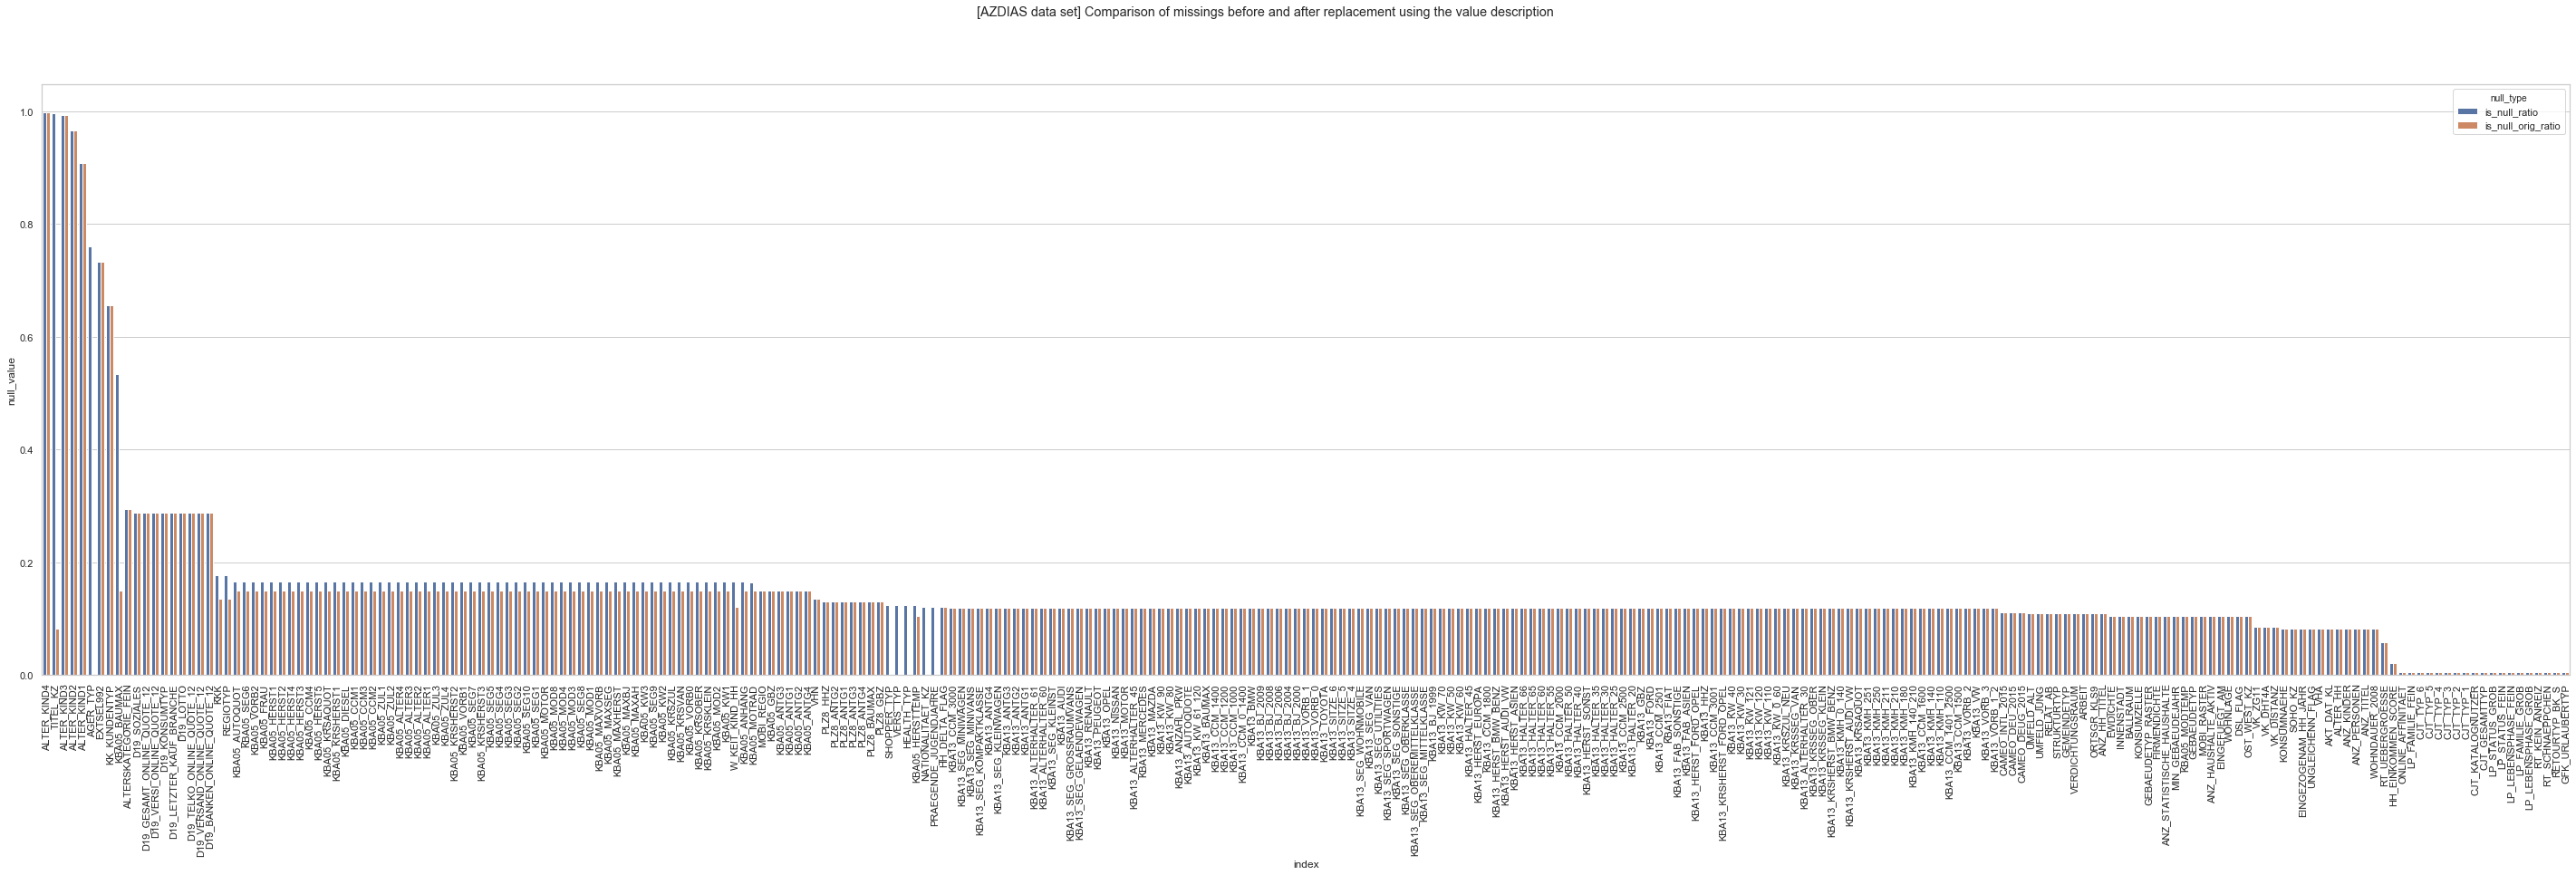

In [32]:
# Plotting a barchart to compare the new missings
sns.set(style='whitegrid')
cfg_figsize = (50, 12)
fig, ax = plt.subplots(figsize=cfg_figsize)
fig.suptitle('[AZDIAS data set] Comparison of missings before and after replacement using the value description')
#ax = sns.barplot(y='index', x='is_null_orig_ratio', data=desc_azdias_nulls[['is_null_ratio', 'is_null_orig_ratio']].reset_index(), orient='h')

df_t = pd.melt(desc_azdias_nulls[['is_null_ratio', 'is_null_orig_ratio']].reset_index(), id_vars =['index']
        , value_vars=['is_null_ratio', 'is_null_orig_ratio'], var_name='null_type', value_name='null_value')
df_t = df_t.sort_values(by='null_value', ascending=False)
df_t = df_t[df_t['null_value'] > 0] # show only columns w/ missing

ax = sns.barplot(x='index', y='null_value', hue='null_type', data=df_t, orient='v')
#ax.set(xlabel='X axis label', ylabel='Y axis label')
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
plt.show()

In [33]:
# Which columns contain the most missing values?
desc_azdias_nulls.sort_values(by=['is_null_ratio'], ascending=[False]).head(10)

# >> Result: As you can see, there are 5 columns which are more than 90% missing: ['ALTER_KIND4', 'TITEL_KZ', 'ALTER_KIND3', 'ALTER_KIND2', 'ALTER_KIND1']

,is_null_count,is_null_ratio,is_null_orig_count,is_null_orig_ratio
ALTER_KIND4,890016,0.998648,890016,0.998648
TITEL_KZ,889061,0.997576,73499,0.082470
ALTER_KIND3,885051,0.993077,885051,0.993077
ALTER_KIND2,861722,0.966900,861722,0.966900
ALTER_KIND1,810163,0.909048,810163,0.909048
AGER_TYP,677503,0.760196,0,0.000000
EXTSEL992,654153,0.733996,654153,0.733996
KK_KUNDENTYP,584612,0.655967,584612,0.655967
KBA05_BAUMAX,476524,0.534687,133324,0.149597
ALTERSKATEGORIE_FEIN,262947,0.295041,262947,0.295041


Now, check the _customers_ data set

In [34]:
# Replace "unknown" values with "NaN" by using mapping of the feature (column) description file

customers_nan = customers.copy()

for index, row in desc_azdias[~desc_azdias['Unknown_Indicator'].isnull()][['Attribute','Unknown_Indicator']].iterrows():
    if row['Attribute'] in customers_nan.columns.tolist():

        c_row_dtype = customers_nan[row['Attribute']].dtype # store dtype temporarily
        c_replace_dict = {}
        
        #azdias_nan[row['Attribute']] = azdias_nan[row['Attribute']].astype(str) # Cast to string
        
        for val in str(row['Unknown_Indicator']).split(','):
            if (c_row_dtype != 'object'):
                val = int(val)
            
            c_replace_dict.update({val: np.nan}) # build up the dict for replacement
        
        customers_nan[row['Attribute']].replace(c_replace_dict, inplace=True) # replace the values by nan to recieve the correct missings
        
        #azdias[row['Attribute']] = azdias[row['Attribute']].astype(c_row_dtype) # Convert dtype back to original one!

In [35]:
# Prepare a description DataFrame holding information about the original DataFrame and the transformed DataFrame in order to understand "missings" and "unkown" data points
desc_customers_nulls = pd.DataFrame({'is_null_count': customers_nan.isnull().sum(), 'is_null_ratio': customers_nan.isnull().mean()
                                , 'is_null_orig_count': customers.isnull().sum(), 'is_null_orig_ratio': customers.isnull().mean()})
desc_customers_nulls.head().sort_values(by='is_null_ratio', ascending=False)

# Result: There are a lot more missings, I need to use the description file to mask the real missing values (some of them are masked as "-1" or "0")

,is_null_count,is_null_ratio,is_null_orig_count,is_null_orig_ratio
ALTER_KIND1,179886,0.938607,179886,0.938607
AGER_TYP,92107,0.480595,0,0.000000
AKT_DAT_KL,46596,0.243128,46596,0.243128
ALTER_HH,46596,0.243128,46596,0.243128
LNR,0,0.000000,0,0.000000


In [36]:
# Might the remaining columns contain also "unknown" values? I'm looking for -1. But seems to be fine
customers[[x.upper() for x in cols_diff]].min()

AKT_DAT_KL                       1.0
ALTER_KIND1                      2.0
ALTER_KIND2                      2.0
ALTER_KIND3                      5.0
ALTER_KIND4                      8.0
ALTERSKATEGORIE_FEIN             0.0
ANZ_KINDER                       0.0
ANZ_STATISTISCHE_HAUSHALTE       0.0
ARBEIT                           1.0
CJT_KATALOGNUTZER                1.0
CJT_TYP_1                        1.0
CJT_TYP_2                        1.0
CJT_TYP_3                        1.0
CJT_TYP_4                        1.0
CJT_TYP_5                        1.0
CJT_TYP_6                        1.0
D19_BUCH_CD                      0.0
D19_KONSUMTYP_MAX                1.0
D19_SOZIALES                     0.0
D19_TELKO_ONLINE_QUOTE_12        0.0
D19_VERSI_DATUM                  1.0
D19_VERSI_OFFLINE_DATUM          1.0
D19_VERSI_ONLINE_DATUM           1.0
D19_VERSI_ONLINE_QUOTE_12        0.0
DSL_FLAG                         0.0
EINGEZOGENAM_HH_JAHR          1986.0
EXTSEL992                        1.0
F

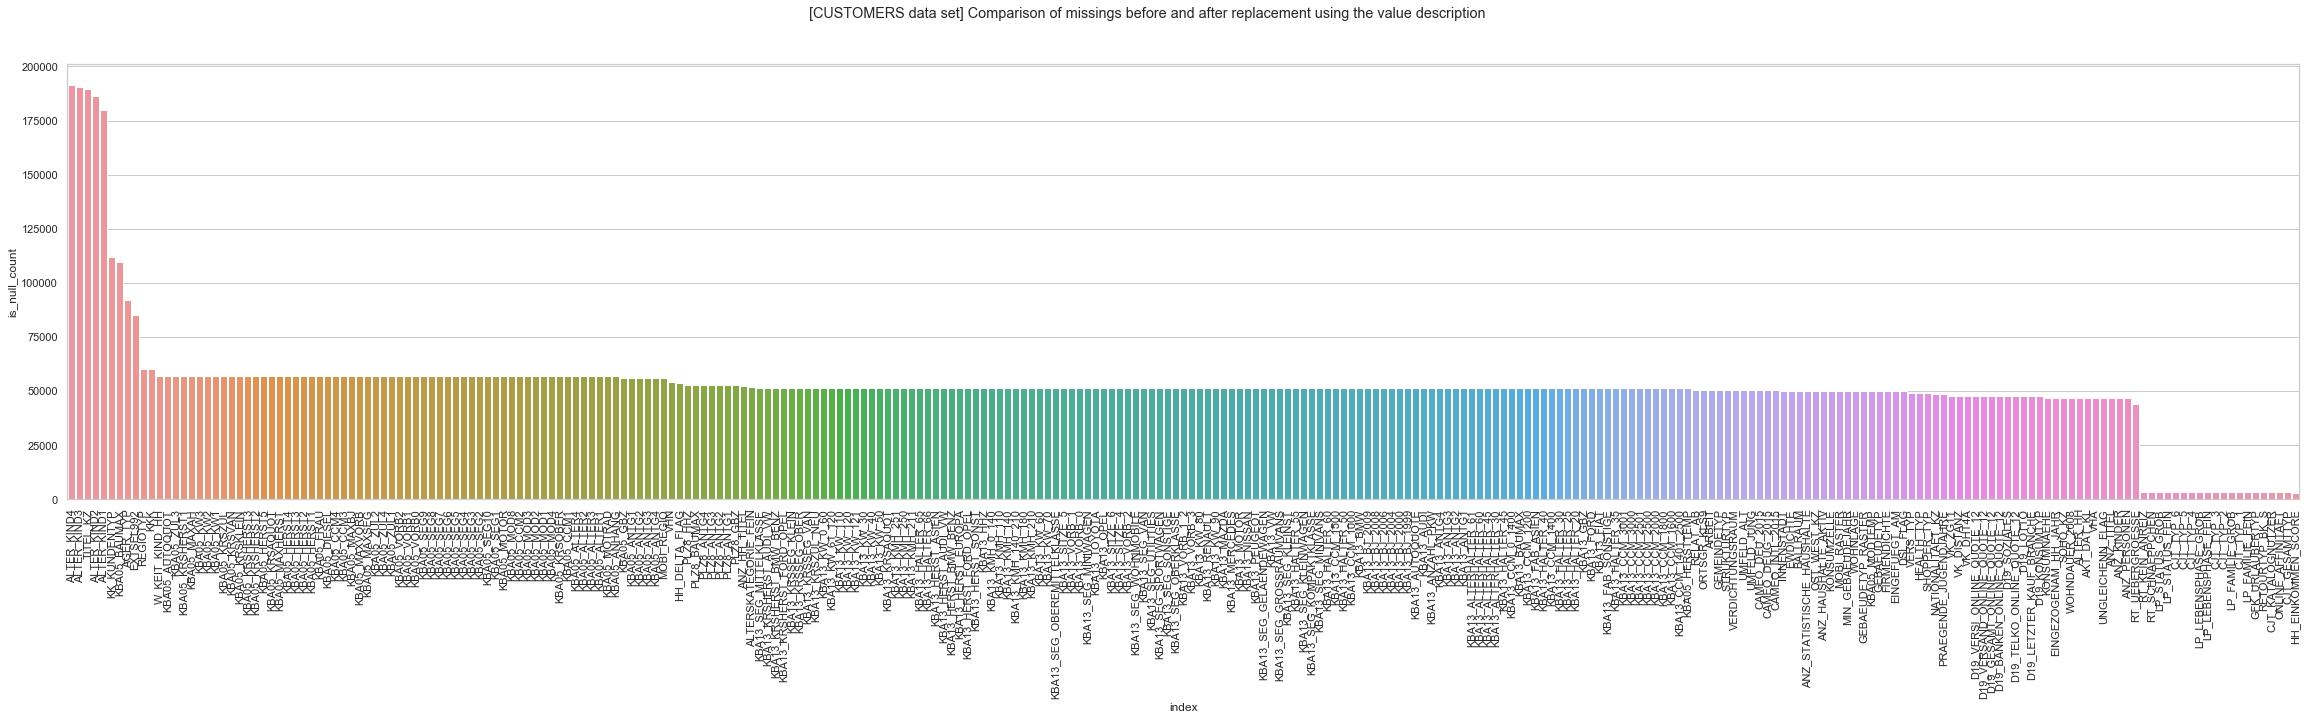

In [37]:
# Plotting a barchart to compare the new missings
sns.set(style='whitegrid')
cfg_figsize = (40, 8)
fig, ax = plt.subplots(figsize=cfg_figsize)
fig.suptitle('[CUSTOMERS data set] Comparison of missings before and after replacement using the value description')
#ax = sns.barplot(y='index', x='is_null_orig_ratio', data=desc_azdias_nulls[['is_null_ratio', 'is_null_orig_ratio']].reset_index(), orient='h')

df_t = pd.melt(desc_customers_nulls[['is_null_ratio', 'is_null_orig_ratio']].reset_index(), id_vars =['index']
        , value_vars=['is_null_ratio', 'is_null_orig_ratio'], var_name='null_type', value_name='null_value')

# ax = sns.barplot(y='index', x='null_value', hue='null_type', data=df_t, orient='h')
ax = sns.barplot(x='index', y='is_null_count', data=desc_customers_nulls[desc_customers_nulls['is_null_count'] > 0].reset_index().sort_values(by='is_null_count', ascending=False), orient='v')
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
#ax.set(xlabel='X axis label', ylabel='Y axis label')
plt.show()

In [38]:
# Which columns contain the most missing values?
desc_customers_nulls.sort_values(by=['is_null_ratio'], ascending=[False]).head(10)

# >> Result: As you can see, there are 5 columns which are more than 90% missing: ['ALTER_KIND4', 'ALTER_KIND3', 'TITEL_KZ', 'ALTER_KIND2', 'ALTER_KIND1']

,is_null_count,is_null_ratio,is_null_orig_count,is_null_orig_ratio
ALTER_KIND4,191416,0.998769,191416,0.998769
ALTER_KIND3,190377,0.993347,190377,0.993347
TITEL_KZ,189340,0.987936,46596,0.243128
ALTER_KIND2,186552,0.973389,186552,0.973389
ALTER_KIND1,179886,0.938607,179886,0.938607
KK_KUNDENTYP,111937,0.584064,111937,0.584064
KBA05_BAUMAX,109535,0.571531,55980,0.292092
AGER_TYP,92107,0.480595,0,0.000000
EXTSEL992,85283,0.444989,85283,0.444989
KKK,60064,0.313401,54260,0.283117


#### Checking Missings per observation (row-wise)

In [39]:
azdias_nan.isnull().mean(axis=1).reset_index(name='is_null_ratio').rename({'index':'row_index'}, axis=1).head()

,row_index,is_null_ratio
0,0,0.704918
1,1,0.046448
2,2,0.021858
3,3,0.027322
4,4,0.021858


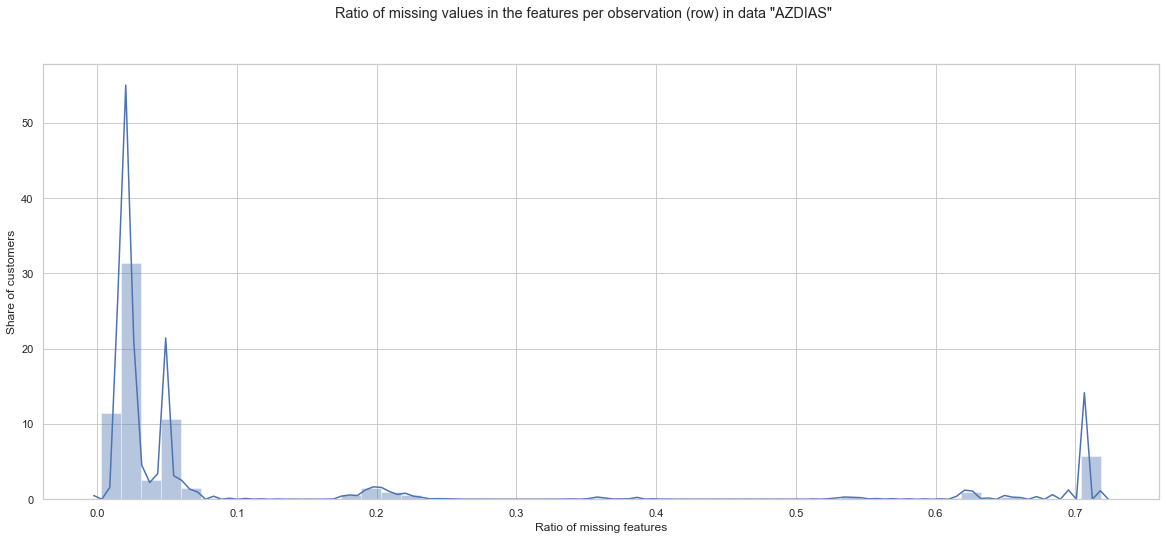

In [40]:
# Plotting a barchart to compare the new missings
sns.set(style='whitegrid')
cfg_figsize = (20, 8)
fig, ax = plt.subplots(figsize=cfg_figsize)
fig.suptitle('Ratio of missing values in the features per observation (row) in data "AZDIAS"')
ax = sns.distplot(azdias_nan.isnull().mean(axis=1).reset_index(name='is_null_ratio')['is_null_ratio'])
ax.set(xlabel='Ratio of missing features', ylabel='Share of customers')
plt.show()

In [41]:
cutoff_ratio = 0.7
df_t = azdias_nan.isnull().mean(axis=1).reset_index(name='is_null_ratio')
print('There are {} ({}%) observations which have more than {}% missing features.'.format(df_t[df_t['is_null_ratio'] > cutoff_ratio]['index'].nunique()
                                                                                           , round(df_t[df_t['is_null_ratio'] > cutoff_ratio]['index'].nunique()/ df_t.shape[0] * 100, 2)
                                                                                           , round(cutoff_ratio*100))) 

There are 73517 (8.25%) observations which have more than 70% missing features.


Now looking at the _customers_ data set

In [42]:
share_missings = missing_observation(azdias)

For the ratio 10% missings of columns per observation there are 140484 (16%) observations.
For the ratio 20% missings of columns per observation there are 118087 (13%) observations.
For the ratio 30% missings of columns per observation there are 105805 (12%) observations.
For the ratio 40% missings of columns per observation there are 99264 (11%) observations.
For the ratio 50% missings of columns per observation there are 99231 (11%) observations.
For the ratio 60% missings of columns per observation there are 93168 (10%) observations.
For the ratio 70% missings of columns per observation there are 17 (0%) observations.
For the ratio 80% missings of columns per observation there are 0 (0%) observations.
For the ratio 90% missings of columns per observation there are 0 (0%) observations.
For the ratio 100% missings of columns per observation there are 0 (0%) observations.


In [43]:
share_missings = missing_observation(azdias_nan)

For the ratio 10% missings of columns per observation there are 154634 (17%) observations.
For the ratio 20% missings of columns per observation there are 131382 (15%) observations.
For the ratio 30% missings of columns per observation there are 105807 (12%) observations.
For the ratio 40% missings of columns per observation there are 100266 (11%) observations.
For the ratio 50% missings of columns per observation there are 99968 (11%) observations.
For the ratio 60% missings of columns per observation there are 93174 (10%) observations.
For the ratio 70% missings of columns per observation there are 73517 (8%) observations.
For the ratio 80% missings of columns per observation there are 0 (0%) observations.
For the ratio 90% missings of columns per observation there are 0 (0%) observations.
For the ratio 100% missings of columns per observation there are 0 (0%) observations.


In [44]:
share_missings = missing_observation(customers)

For the ratio 10% missings of columns per observation there are 56574 (30%) observations.
For the ratio 20% missings of columns per observation there are 52572 (27%) observations.
For the ratio 30% missings of columns per observation there are 51281 (27%) observations.
For the ratio 40% missings of columns per observation there are 50763 (26%) observations.
For the ratio 50% missings of columns per observation there are 50751 (26%) observations.
For the ratio 60% missings of columns per observation there are 49911 (26%) observations.
For the ratio 70% missings of columns per observation there are 3 (0%) observations.
For the ratio 80% missings of columns per observation there are 0 (0%) observations.
For the ratio 90% missings of columns per observation there are 0 (0%) observations.
For the ratio 100% missings of columns per observation there are 0 (0%) observations.


In [45]:
share_missings = missing_observation(customers_nan)

For the ratio 10% missings of columns per observation there are 57491 (30%) observations.
For the ratio 20% missings of columns per observation there are 53348 (28%) observations.
For the ratio 30% missings of columns per observation there are 51281 (27%) observations.
For the ratio 40% missings of columns per observation there are 50798 (27%) observations.
For the ratio 50% missings of columns per observation there are 50786 (26%) observations.
For the ratio 60% missings of columns per observation there are 49929 (26%) observations.
For the ratio 70% missings of columns per observation there are 40967 (21%) observations.
For the ratio 80% missings of columns per observation there are 0 (0%) observations.
For the ratio 90% missings of columns per observation there are 0 (0%) observations.
For the ratio 100% missings of columns per observation there are 0 (0%) observations.


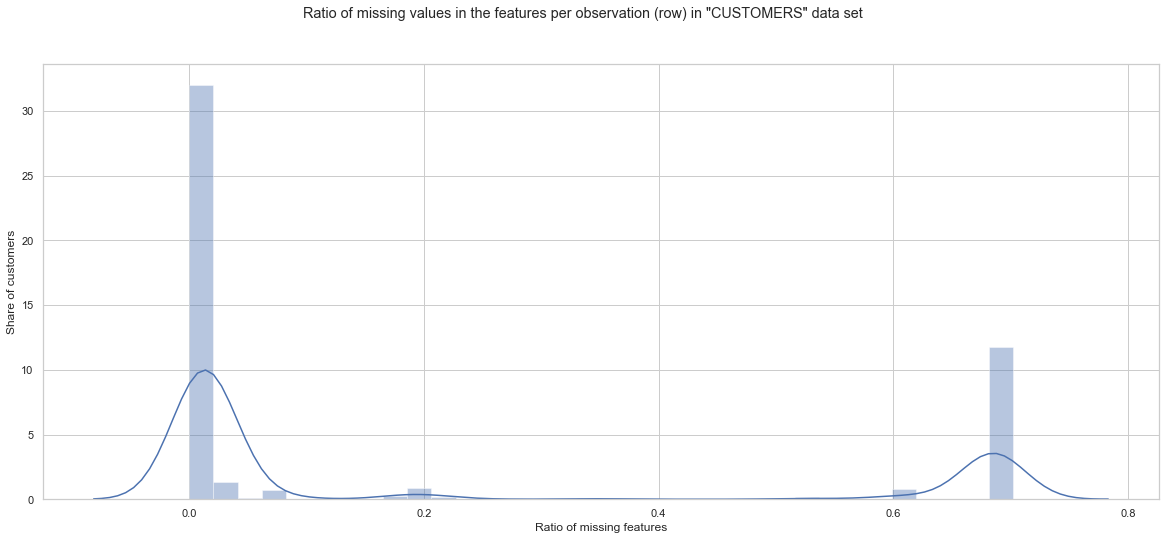

In [46]:
# Plotting a barchart to compare the new missings
sns.set(style='whitegrid')
cfg_figsize = (20, 8)
fig, ax = plt.subplots(figsize=cfg_figsize)
fig.suptitle('Ratio of missing values in the features per observation (row) in "CUSTOMERS" data set')
ax = sns.distplot(customers.isnull().mean(axis=1).reset_index(name='is_null_ratio')['is_null_ratio'])
ax.set(xlabel='Ratio of missing features', ylabel='Share of customers')
plt.show()

In [47]:
# azdias.describe().transpose().to_excel('desc_dataframes.xlsx', sheet_name='df_azdias') # Exporting to excel for better readability
# azdias.describe().transpose().head()

,count,mean,std,min,25%,50%,75%,max
LNR,891221.0,637263.000000,257273.486466,191653.0,414458.0,637263.0,860068.0,1082873.0
AGER_TYP,891221.0,-0.358435,1.198724,-1.0,-1.0,-1.0,-1.0,3.0
AKT_DAT_KL,817722.0,4.421928,3.638805,1.0,1.0,3.0,9.0,9.0
ALTER_HH,817722.0,10.864126,7.639683,0.0,0.0,13.0,17.0,21.0
ALTER_KIND1,81058.0,11.745392,4.097660,2.0,8.0,12.0,15.0,18.0


**Results**
* The data set "_azdias_" contains 891,221 observations with 366 features. This data set comes with a data description file which provides further information for 272 of the 366 attributes.  --> For 94 attributes, we got no further information.
* Missing Values
 * The _azdias_ DF contains missings, but even more, if you transform the "unknown" label into missings. This can be done by using the data description file.
 * There are 73,517 (8.25%) observations which have more than 70.0% missing features.
 
Number of missing columns in the description file: 94
Number of missing columns (require also missing information) in the description file: 142
Number of missing columns (require also missing information) in the description file: 141


In [48]:
# customers.describe().transpose().to_excel('desc_dataframes.xlsx', sheet_name='df_customers') # Exporting to excel for better readability
# customers.describe().transpose().head()

,count,mean,std,min,25%,50%,75%,max
LNR,191652.0,95826.500000,55325.311233,1.0,47913.75,95826.5,143739.25,191652.0
AGER_TYP,191652.0,0.344359,1.391672,-1.0,-1.00,0.0,2.00,3.0
AKT_DAT_KL,145056.0,1.747525,1.966334,1.0,1.00,1.0,1.00,9.0
ALTER_HH,145056.0,11.352009,6.275026,0.0,8.00,11.0,16.00,21.0
ALTER_KIND1,11766.0,12.337243,4.006050,2.0,9.00,13.0,16.00,18.0


## Data Preparation

#### Removing columns

In [49]:
# remove columns with high dimensionality
customers_nan.select_dtypes(object).describe()

,CAMEO_DEU_2015,CAMEO_DEUG_2015,CAMEO_INTL_2015,D19_LETZTER_KAUF_BRANCHE,EINGEFUEGT_AM,OST_WEST_KZ,PRODUCT_GROUP,CUSTOMER_GROUP
count,141224,141224,141224,143955,141725,141725,191652,191652
unique,45,19,43,35,3034,2,3,2
top,2D,2,14,D19_UNBEKANNT,1992-02-10 00:00:00,W,COSMETIC_AND_FOOD,MULTI_BUYER
freq,11208,17574,14708,31910,64744,130382,100860,132238


In [50]:
# remove those features with high unique values
print('shapes before column removal:')
print('\t',azdias_nan.shape)
print('\t',customers_nan.shape)

# Remove high dimensionality columns
azdias_nan.drop(['EINGEFUEGT_AM'], axis=1, inplace=True)
customers_nan.drop(['EINGEFUEGT_AM'], axis=1, inplace=True)

# Drop exclusive columns from "customers" data set
customers_nan.drop(['ONLINE_PURCHASE', 'PRODUCT_GROUP', 'CUSTOMER_GROUP'], axis=1, inplace=True)

print('shapes after column removal:')
print('\t',azdias_nan.shape)
print('\t',customers_nan.shape)

shapes before column removal:
	 (891221, 366)
	 (191652, 369)
shapes after column removal:
	 (891221, 365)
	 (191652, 365)


In [51]:
azdias_nan.dtypes.reset_index(name='data_type').groupby('data_type').agg({'index':'count'})

,index
data_type,
int64,87
float64,273
object,5


In [52]:
customers_nan.dtypes.reset_index(name='data_type').groupby('data_type').agg({'index':'count'})

,index
data_type,
int64,87
float64,273
object,5


### Encoding of values

#### Manual Encoding

The data sets seem to contain following data types:
* continuous
* ordinal
* categorical
* mixed

Re-encode mixed features: _CAMEO_DEU_2015, CAMEO_DEUG_2015, CAMEO_INTL_2015_

In [53]:
# re-encoding for "CAMEO_DEU_2015". This is a categorical, but ordered variable
values = ['1A', '1B', '1C', '1D', '1E', '2A', '2B', '2C', '2D', '3A', '3B', '3C', '3D', '4A', '4B', '4C', '4D', '4E', '5A', '5B', '5C', '5D', '5E', '5F', '6A', '6B', '6C', '6D', '6E', '6F', '7A', '7B', '7C', '7D', '7E', '8A', '8B', '8C', '8D', '9A', '9B', '9C', '9D', '9E']
replace_dict = {}
for i, val in enumerate(values):
    replace_dict.update({val: i+1})
replace_dict.update({'XX': None})

# Apply on both data sets
azdias_nan['CAMEO_DEU_2015'].replace(replace_dict, inplace=True)
customers_nan['CAMEO_DEU_2015'].replace(replace_dict, inplace=True)

In [54]:
# re-encoding for "CAMEO_INTL_2015". This is a categorical, but ordered variable
values = ['11', '12', '13', '14', '15', '21', '22', '23', '24', '25', '31', '32', '33', '34', '35', '41', '42', '43', '44', '45', '51', '52', '53', '54', '55']
replace_dict = {}
for i, val in enumerate(values):
    replace_dict.update({val: i+1})
replace_dict.update({'XX': None})

# Apply on both data sets
azdias_nan['CAMEO_INTL_2015'] = azdias_nan['CAMEO_INTL_2015'].apply(lambda x: str(x).strip('.0'))
customers_nan['CAMEO_INTL_2015'] = customers_nan['CAMEO_INTL_2015'].apply(lambda x: str(x).strip('.0')) # cast to string, remove tailing ".0"

azdias_nan['CAMEO_INTL_2015'] = azdias_nan['CAMEO_INTL_2015'].map(replace_dict)
customers_nan['CAMEO_INTL_2015'] = customers_nan['CAMEO_INTL_2015'].map(replace_dict)
#azdias_nan['CAMEO_INTL_2015'].replace(replace_dict, inplace=True)
#customers_nan['CAMEO_INTL_2015'].replace(replace_dict, inplace=True)

In [55]:
# re-encoding for "CAMEO_DEUG_2015". This is a categorical, but ordered variable
replace_dict = {}
replace_dict.update({'X': None})

# Apply on both data sets
azdias_nan['CAMEO_DEUG_2015'] = azdias_nan['CAMEO_DEUG_2015'].apply(lambda x: str(x).strip('.0'))
customers_nan['CAMEO_DEUG_2015'] = customers_nan['CAMEO_DEUG_2015'].apply(lambda x: str(x).strip('.0')) # cast to string, remove tailing ".0"

azdias_nan['CAMEO_DEUG_2015'] = azdias_nan['CAMEO_DEUG_2015'].map(replace_dict)
customers_nan['CAMEO_DEUG_2015'] = customers_nan['CAMEO_DEUG_2015'].map(replace_dict)
#azdias_nan['CAMEO_INTL_2015'].replace(replace_dict, inplace=True)
#customers_nan['CAMEO_INTL_2015'].replace(replace_dict, inplace=True)

#### Automatic Encoding

In [56]:
print(azdias_nan.shape)
print(customers_nan.shape)

(891221, 365)
(191652, 365)


In [57]:
# All categories will be encoded by numerics
azdias_nan = pd.get_dummies(azdias_nan)
customers_nan = pd.get_dummies(customers_nan)

In [58]:
print(azdias_nan.shape)
print(customers_nan.shape)

(891221, 399)
(191652, 399)


### Highly correlated features

In [59]:
corr_azdias = azdias.corr().abs()

In [60]:
# Select upper triangle of correlation matrix
upper = corr_azdias.where(np.triu(np.ones(corr_azdias.shape), k=1).astype(np.bool))

# Find index of feature columns with correlation greater than 0.95
cols_to_drop = [column for column in upper.columns if any(upper[column] > 0.95)] # Due to the high number of features (~366 as input), I could lower this threshold to ~ 0.75. This will remove furthermore columns.

# I want to keep the "ALTER_KINDx" variables.
cols_to_drop = [x for x in cols_to_drop if 'ALTER_KIND' not in x]
print('Columns with high correlation:', cols_to_drop)

Columns with high correlation: ['ANZ_STATISTISCHE_HAUSHALTE', 'D19_VERSAND_ONLINE_DATUM', 'KBA13_HERST_SONST', 'KBA13_KMH_250', 'LP_FAMILIE_GROB', 'LP_LEBENSPHASE_GROB', 'LP_STATUS_GROB', 'PLZ8_BAUMAX', 'PLZ8_GBZ', 'PLZ8_HHZ']


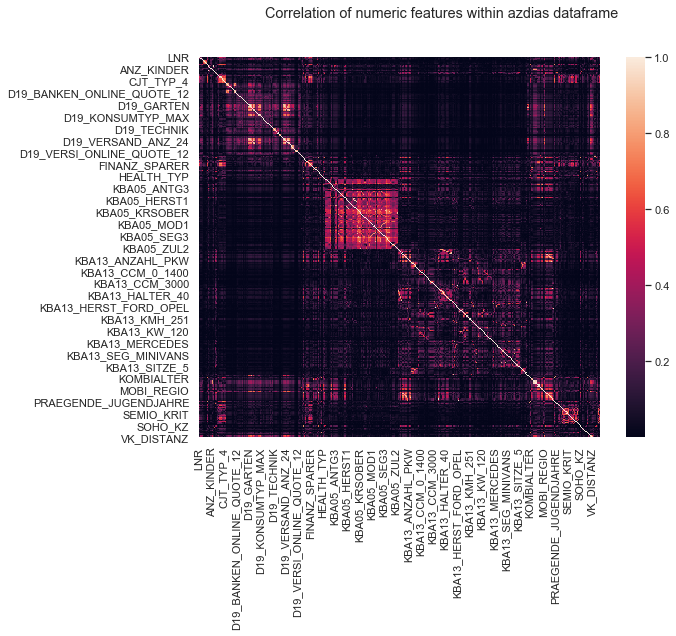

In [61]:
# Plotting a barchart to compare the new missings
sns.set(style='darkgrid')
cfg_figsize = (9, 7)
fig, ax = plt.subplots(figsize=cfg_figsize)
fig.suptitle('Correlation of numeric features within azdias dataframe')
ax = sns.heatmap(corr_azdias)
#ax.set(xlabel='Ratio of missing features', ylabel='Share of customers')
plt.show()

In [62]:
# Drop highly correlated features
azdias_nan.drop(azdias_nan[cols_to_drop], axis=1, inplace=True)
customers_nan.drop(customers_nan[cols_to_drop], axis=1, inplace=True)

In [63]:
print(azdias_nan.shape)
print(customers_nan.shape)

(891221, 389)
(191652, 389)


In [64]:
desc_azdias['flag_drop_correlation'] = False
desc_azdias.loc[desc_azdias['Attribute'].isin(cols_to_drop), 'flag_drop_correlation'] = True # mark down the attributes, which were dropped due to high correlation

In [65]:
desc_azdias[desc_azdias['flag_drop_correlation']]

,Attribute,Description,Type,Unknown_Indicator,Information level,flag_drop_correlation
67,D19_VERSAND_ONLINE_DATUM,actuality of the last transaction for the segm...,categorical,NaN,Household,True
205,KBA13_HERST_SONST,share of other cars within the PLZ8,categorical,-1,PLZ8,True
212,KBA13_KMH_250,share of cars with max speed between 210 and 2...,categorical,-1,PLZ8,True
269,LP_FAMILIE_GROB,familytyp rough,categorical,NaN,Person,True
271,LP_LEBENSPHASE_GROB,lifestage rough,categorical,NaN,Person,True
273,LP_STATUS_GROB,social status rough,categorical,NaN,Person,True
284,PLZ8_BAUMAX,most common building-type within the PLZ8,categorical,NaN,PLZ8,True
285,PLZ8_GBZ,number of buildings within the PLZ8,categorical,-1,PLZ8,True
286,PLZ8_HHZ,number of households within the PLZ8,categorical,-1,PLZ8,True


### Missing Value Imputation
* customized imputing for "KIND_ALTER"

Missing imputation logic for features "KIND_ALTER3" and "KIND_ALTER4"
* There are cases on both data sets, where "ANZ_KINDER" is for example >= 4, but the age ("ALTER_KIND4") is missing. My approach is to take the average distance of remaining children ages to guess the age of the 4th (resp. 3rd) child. The same is done on the feature "ALTER_KIND3".
* **Annotation for reviewer**: This is an example of understanding the business logic (referring to CRISP-DM) and using this information to improve the technical data quality. Depending on the given project resources, this should be done for more features in the data set. Due to the limited time given on the capstone project, I will not continue to build such customized / business-oriented imputing logics.

In [66]:
# Imputing feature "ALTER_KIND4"
def missing_imputation_kind4(df):
    print('>> Starting imputation logic for feature "ALTER_KIND4" on dataframe')
    idx = df[(df['ANZ_KINDER'] >= 4) & (df['ALTER_KIND4'].isnull())][['ANZ_KINDER', 'ALTER_KIND4']].index.tolist()
    print('\tbefore imputation, there are {} missing observations.'.format(len(idx)))

    dict_imputation = {}
    for i in idx:
        ages = []
        ages_dist = []
        ages = [int(x) for x in df.loc[i][['ALTER_KIND1', 'ALTER_KIND2', 'ALTER_KIND3']].tolist() if str(x) != 'nan']

        if len(ages) > 1:
            if len(ages) == 3:
                ages_dist.append(ages[2] - ages[1])
            if len(ages) >= 2:
                ages_dist.append(ages[1] - ages[0])

            #print('index:', i)
            #print('ages:', ages)
            #print('ages_dist:', ages_dist)
            imputed_age = max(ages) + (sum(ages_dist) / len(ages_dist))

            dict_imputation.update({i: imputed_age})

    # Apply the extracted imputing values on DataFrame
    for key, val in dict_imputation.items():
        df.loc[key, 'ALTER_KIND4'] = val
    
    idx = df[(df['ANZ_KINDER'] >= 4) & (df['ALTER_KIND4'].isnull())][['ANZ_KINDER', 'ALTER_KIND4']].index.tolist()
    print('\tafter imputation, there are {} missing observations remaining.'.format(len(idx)))
    
    return df


azdias_nan = missing_imputation_kind4(azdias_nan)
customers_nan = missing_imputation_kind4(customers_nan)

>> Starting imputation logic for feature "ALTER_KIND4" on dataframe
	before imputation, there are 129 missing observations.
	after imputation, there are 5 missing observations remaining.
>> Starting imputation logic for feature "ALTER_KIND4" on dataframe
	before imputation, there are 25 missing observations.
	after imputation, there are 1 missing observations remaining.


In [67]:
# Imputing feature "ALTER_KIND3"
def missing_imputation_kind3(df):
    print('>> Starting imputation logic for feature "ALTER_KIND3" on dataframe')
    idx = df[(df['ANZ_KINDER'] >= 3) & (df['ALTER_KIND3'].isnull())][['ANZ_KINDER', 'ALTER_KIND3']].index.tolist()
    print('\tbefore imputation, there are {} missing observations.'.format(len(idx)))

    dict_imputation = {}
    for i in idx:
        ages = []
        ages_dist = []
        ages = [int(x) for x in df.loc[i][['ALTER_KIND1', 'ALTER_KIND2']].tolist() if str(x) != 'nan']

        if len(ages) > 1:
            if len(ages) == 2:
                ages_dist.append(ages[1] - ages[0])

            #print('index:', i)
            #print('ages:', ages)
            #print('ages_dist:', ages_dist)
            imputed_age = max(ages) + (sum(ages_dist) / len(ages_dist))

            dict_imputation.update({i: imputed_age})

    # Apply the extracted imputing values on DataFrame
    for key, val in dict_imputation.items():
        df.loc[key, 'ALTER_KIND3'] = val
    
    idx = df[(df['ANZ_KINDER'] >= 3) & (df['ALTER_KIND3'].isnull())][['ANZ_KINDER', 'ALTER_KIND3']].index.tolist()
    print('\tafter imputation, there are {} missing observations remaining.'.format(len(idx)))
    
    return df


azdias_nan = missing_imputation_kind3(azdias_nan)
customers_nan = missing_imputation_kind3(customers_nan)

>> Starting imputation logic for feature "ALTER_KIND3" on dataframe
	before imputation, there are 583 missing observations.
	after imputation, there are 38 missing observations remaining.
>> Starting imputation logic for feature "ALTER_KIND3" on dataframe
	before imputation, there are 105 missing observations.
	after imputation, there are 8 missing observations remaining.


Missing imputation logic for remaining columns
* Annotation: This could be more advanced. E.g. differentiate between 

#### Missing Value Imputation on observations (rows)
* During _data exploration_ I found out, that set a threshold of 30% missing of all features per row, I would remove 12% (105807) from azdias and 27% (51281) from customers data set (_numbers refer to the original dataset before any filtering or prep_)

In [68]:
azdias_nan.shape

(891221, 389)

In [69]:
threshold = 0.3 # All observations which contain more than 30% missing columns will be removed from both data sets

# Handling "azdias" data set
df_t = azdias_nan.isnull().mean(axis=1).reset_index(name='missing_ratio')#.sort_values(by='missing_ratio', ascending=False)
print('Removing {} ({}%) rows from data set.'.format(df_t[df_t['missing_ratio'] > threshold].shape[0], round(df_t[df_t['missing_ratio'] > threshold].shape[0] / azdias_nan.shape[0] * 100, 2)))
azdias_nan = azdias_nan[~azdias_nan.index.isin(df_t[df_t['missing_ratio'] > threshold].index.tolist())].copy()
print('azdias_nan DF:', azdias_nan.shape)

# Handling "customers" data set
df_t = customers_nan.isnull().mean(axis=1).reset_index(name='missing_ratio')#.sort_values(by='missing_ratio', ascending=False)
print('Removing {} ({}%) rows from data set.'.format(df_t[df_t['missing_ratio'] > threshold].shape[0], round(df_t[df_t['missing_ratio'] > threshold].shape[0] / customers_nan.shape[0] * 100, 2)))
customers_nan = customers_nan[~customers_nan.index.isin(df_t[df_t['missing_ratio'] > threshold].index.tolist())].copy()
print('azdias_nan DF:', customers_nan.shape)

Removing 105800 (11.87%) rows from data set.
azdias_nan DF: (785421, 389)
Removing 51281 (26.76%) rows from data set.
azdias_nan DF: (140371, 389)


In [70]:
print('Number of columns in "azdias" DataFrame:    ', len(azdias_nan.columns.tolist()))
print('Number of columns in "customers" DataFrame: ', len(customers_nan.columns.tolist()))

print('Columns, which are not in "customers" DataFrame, but in "azdias" Data Frame:', list(set(azdias_nan.columns.tolist()).difference(set(customers_nan.columns.tolist()))))
print('Columns, which are not in "azdias" DataFrame, but in "customers" Data Frame:', list(set(customers_nan.columns.tolist()).difference(set(azdias_nan.columns.tolist()))))

Number of columns in "azdias" DataFrame:     389
Number of columns in "customers" DataFrame:  389
Columns, which are not in "customers" DataFrame, but in "azdias" Data Frame: []
Columns, which are not in "azdias" DataFrame, but in "customers" Data Frame: []


#### Missing Value Imputation on features (columns)
* Using the _SimpleImputer_ provided by scikitlearn

In [71]:
# Initiate SimpleImputer, using different strategies

imp_const = SimpleImputer(missing_values=np.nan, strategy='constant', fill_value=0)
imp_mostfreq = SimpleImputer(missing_values='NaN', strategy='most_frequent')

In [72]:
# Fit & transform data sets
azdias_imp = pd.DataFrame(imp_const.fit_transform(azdias_nan), columns=azdias_nan.columns)

In [73]:
customers_imp = pd.DataFrame(imp_const.fit_transform(customers_nan), columns=customers_nan.columns)

In [74]:
# Alternative: Use pandas fillna method
#azdias_imp = azdias_nan[cols_to_impute].fillna(0)
#customers_imp = customers_nan[cols_to_impute].fillna(0)

In [75]:
#print(azdias_imp.isnull().mean().reset_index(name='missing_ratio').sort_values(by='missing_ratio', ascending=False).head())
print(azdias_imp.isnull().mean().reset_index(name='missing_ratio').sort_values(by='missing_ratio', ascending=False).head())
print(customers_imp.isnull().mean().reset_index(name='missing_ratio').sort_values(by='missing_ratio', ascending=False).head())

                        index  missing_ratio
0                         LNR            0.0
244  KBA13_KRSHERST_FORD_OPEL            0.0
266             KBA13_PEUGEOT            0.0
265                KBA13_OPEL            0.0
264              KBA13_NISSAN            0.0
                        index  missing_ratio
0                         LNR            0.0
244  KBA13_KRSHERST_FORD_OPEL            0.0
266             KBA13_PEUGEOT            0.0
265                KBA13_OPEL            0.0
264              KBA13_NISSAN            0.0


### Outlier detection & removal
Removal of outliers by using Z-Score (ref: https://towardsdatascience.com/ways-to-detect-and-remove-the-outliers-404d16608dba)
* for each column a Z-score is calculated, based on the standard deviation. Later this Z-score can be used to remove outliers (values which exceed a defined treshold)

In [76]:
print('[before] Data set shapes:')
print('\tazdias:   ', azdias_imp.shape)
print('\tcustomers:', customers_imp.shape)

threshold = 6

# handle azdias DF
z = np.abs(stats.zscore(azdias_imp))
azdias_imp = azdias_imp[(z < threshold).all(axis=1)]

# handle azdias DF
z = np.abs(stats.zscore(customers_imp))
customers_imp = customers_imp[(z < threshold).all(axis=1)]

print('[afterwards] Data set shapes:')
print('\tazdias:   ', azdias_imp.shape)
print('\tcustomers:', customers_imp.shape)

[before] Data set shapes:
	azdias:    (785421, 389)
	customers: (140371, 389)
[afterwards] Data set shapes:
	azdias:    (558522, 389)
	customers: (94029, 389)


#### Normalization
* Apply _StandardScaler()_ (ref: https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html)
* Target: Prior to using kmeans-clustering algorithm, I will apply PCA for dimensionality reduction. Allthough many of the data set's do not have a vast variance, it is often applied to achieve a better clustering result (ref: https://scikit-learn.org/stable/modules/clustering.html#k-means)

In [77]:
# Applying StandardScaler of scikit-learn package
scl = StandardScaler()

In [78]:
azdias_scl = pd.DataFrame(scl.fit_transform(azdias_imp), columns=azdias_imp.columns)

In [79]:
customers_scl = pd.DataFrame(scl.fit_transform(customers_imp), columns=customers_imp.columns)

In [80]:
#print(azdias_imp.isnull().mean().reset_index(name='missing_ratio').sort_values(by='missing_ratio', ascending=False).head())
print(azdias_scl.isnull().mean().reset_index(name='missing_ratio').sort_values(by='missing_ratio', ascending=False).head())
print(customers_scl.isnull().mean().reset_index(name='missing_ratio').sort_values(by='missing_ratio', ascending=False).head())

                        index  missing_ratio
0                         LNR            0.0
244  KBA13_KRSHERST_FORD_OPEL            0.0
266             KBA13_PEUGEOT            0.0
265                KBA13_OPEL            0.0
264              KBA13_NISSAN            0.0
                        index  missing_ratio
0                         LNR            0.0
244  KBA13_KRSHERST_FORD_OPEL            0.0
266             KBA13_PEUGEOT            0.0
265                KBA13_OPEL            0.0
264              KBA13_NISSAN            0.0


## Part 1: Customer Segmentation Report

The main bulk of your analysis will come in this part of the project. Here, you should use unsupervised learning techniques to describe the relationship between the demographics of the company's existing customers and the general population of Germany. By the end of this part, you should be able to describe parts of the general population that are more likely to be part of the mail-order company's main customer base, and which parts of the general population are less so.

### Apply PCA as preparation for k-means clustering
* ref: https://365datascience.com/pca-k-means/
* PCA (Principle Component Analysis) is often used to reduce the dimension.

In [81]:
def pca_learning(df, pca_n_comp=None, pca_variance_preservation=0.8):
    '''
    INPUT:
    df - (Pandas DataFrame) The prepared (imputed, scaled) Pandas DataFrame
    pca_n_comp - (int) number of principle components
    pca_variance_preservation - (float) between 0.0 and 1.0 which represents the threshold for variance preservation for PCA calculation.
                                        This affects the number of components for PCA.
        
    OUTPUT:
    df_pca - (Pandas DataFrame) Results of PCA
    '''
       
    if ('LNR' in df.columns.tolist()):
        print('LNR found in DataFrame...')
        lnr = df['LNR'].tolist()
        df.drop(['LNR'], axis=1, inplace=True)
    else:
        lnr = []
        
    # Run PCA w/ extracted number of components
    if pca_n_comp != None:
        n_components = pca_n_comp
        print('using {} components for PCA as via parameter'.format(n_components))
    else:
        # Warming up PCA - find number of components
        pca = PCA()
        pca.fit(df)
    
        # Plot explaned, cumulative variance of PCA
        plt.figure(figsize = (25,8))
        plt.plot(range(1,df.shape[1]+1), pca.explained_variance_ratio_.cumsum(), linestyle='--')
        plt.title('Explained Variance by Principle Components')
        plt.xlabel('Number of Components')
        plt.ylabel('Cumulative Explaned Variance')
        plt.show()

        n_components = sum(pca.explained_variance_ratio_.cumsum() <= 0.8)
        print('At a threshold of 80% variance preservation, PCA should be used with at least {} components.'.format(n_components))
        print('using {} components for PCA via automatic identification'.format(n_components))
    
    # apply final PCA
    pca = PCA(n_components=n_components)
    pca.fit(df)
    df_pca = pd.DataFrame(pca.transform(df))
    
    return pd.concat([pd.DataFrame(lnr, columns=['LNR']), df_pca], axis=1), n_components

In [82]:
def cluster_warmup(df_pca, kmeans_min_clusters=1, kmeans_max_clusters=20):
    '''
    INPUT:
    df - (Pandas DataFrame) The prepared (imputed, scaled) Pandas DataFrame
                                  This affects the number of components for PCA.
    kmeans_min_clusters - (int) the lower limit of the range, which should be calculated
    kmeans_max_clusters - (int) the upper limit of the range, which should be calculated
    
    OUTPUT:
    kmeans_n_cluster - (int) Number of principle components for PCA
    n_clusters - (int) Number of k-means clusters
    '''
    if ('LNR' in df_pca.columns.tolist()):
        df_pca.drop(['LNR'], axis=1, inplace=True)
        
    # Warming up K-Means - find number of clusters
    wcss = []
    for i in range(kmeans_min_clusters, kmeans_max_clusters+1):
        print('K-Means warmup - calculating {} clusters...'.format(i))
        kmeans_pca = KMeans(n_clusters=i, init='k-means++', random_state=42)
        kmeans_pca.fit(df_pca)
        wcss.append(kmeans_pca.inertia_)

    plt.figure(figsize = (10,8))
    plt.plot(range(kmeans_min_clusters, kmeans_max_clusters+1), wcss, marker='o', linestyle='--')
    plt.xlabel('Number of Clusters')
    plt.ylabel('Within Cluster Sum of Squares (WCSS)')
    plt.title('K-Means with PCA Clustering')
    plt.show()

    # Using elbow method by using the package "kneebow.Rotor" --> doesn't work.
    wcss_new = []
    for i, val in enumerate(wcss):
        wcss_new.append([i+1, round(val)])

    #Automatically returning the optimum number of clusters
    rotor = Rotor()
    rotor.fit_rotate(wcss_new)
    kmeans_n_cluster = rotor.get_elbow_index()
    print('Using elbow-method, K-Means clustering should be done with {} clusters.'.format(kmeans_n_cluster)) # --> this seems to be buggy

    return kmeans_n_cluster

LNR found in DataFrame...


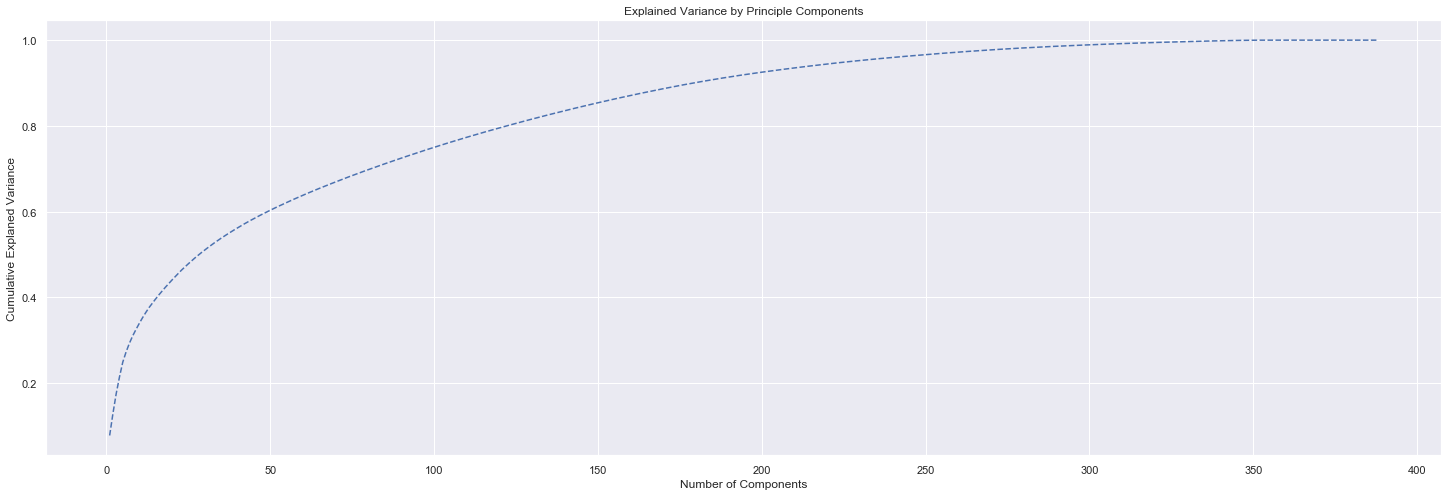

At a threshold of 80% variance preservation, PCA should be used with at least 122 components.
using 122 components for PCA via automatic identification


In [83]:
# Learn & Apply PCA on azdias
azdias_pca, n_components = pca_learning(azdias_scl)

In [84]:
# Apply PCA on customers
customers_pca, pca_n_comp= pca_learning(customers_scl, n_components)

LNR found in DataFrame...
using 122 components for PCA as via parameter


K-Means warmup - calculating 1 clusters...
K-Means warmup - calculating 2 clusters...
K-Means warmup - calculating 3 clusters...
K-Means warmup - calculating 4 clusters...
K-Means warmup - calculating 5 clusters...
K-Means warmup - calculating 6 clusters...
K-Means warmup - calculating 7 clusters...
K-Means warmup - calculating 8 clusters...
K-Means warmup - calculating 9 clusters...
K-Means warmup - calculating 10 clusters...
K-Means warmup - calculating 11 clusters...
K-Means warmup - calculating 12 clusters...
K-Means warmup - calculating 13 clusters...
K-Means warmup - calculating 14 clusters...
K-Means warmup - calculating 15 clusters...
K-Means warmup - calculating 16 clusters...
K-Means warmup - calculating 17 clusters...
K-Means warmup - calculating 18 clusters...
K-Means warmup - calculating 19 clusters...
K-Means warmup - calculating 20 clusters...


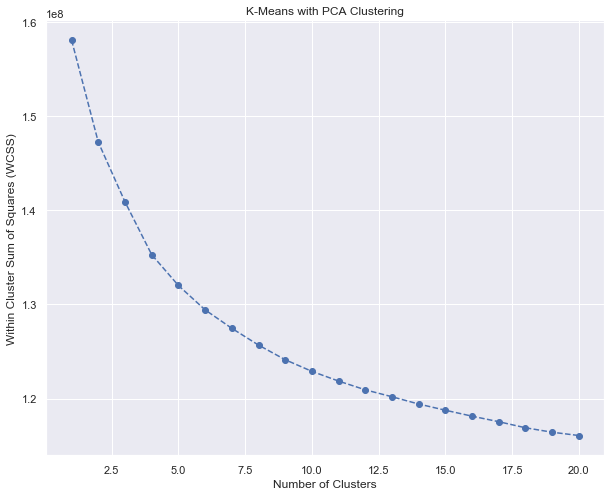

Using elbow-method, K-Means clustering should be done with 0 clusters.


In [85]:
# Find K-Means clusters on azdias
n_kmeans_cls = cluster_warmup(azdias_pca)

Apply K-Means w/ previously learned parameters
* as learned on _customers_ data set, 
 * PCA n_components  = 122
 * KMeans n_clusters = 12

In [89]:
# Learn & fit K-Means on azdias
n_clusters = 12
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
model_kmeans = kmeans.fit(azdias_pca)
azdias_cls = pd.DataFrame(model_kmeans.predict(azdias_pca), columns=['cluster'])

In [91]:
# Training & Fitting K-Means on "customers"
customers_cls = pd.DataFrame(model_kmeans.predict(customers_pca.drop(['LNR'], axis=1)), columns=['cluster'])

In [105]:
# Store K-Means model to disk
filename_model = 'model_kmeans.pkl'

pickle.dump(model_kmeans, open(filename_model, 'wb'))
print('K-Means model stored to disk as {}.'.format(filename_model))

K-Means model stored to disk as model_kmeans.pkl.


#### Comparing both data sets by the identified clusters

In [92]:
# Allocation of observations per cluster
cls_eval = azdias_cls.reset_index().groupby(['cluster']).agg({'index':'count'}).reset_index().rename({'index':'cnt_azdias'}, axis=1).merge(
    customers_cls.reset_index().groupby(['cluster']).agg({'index':'count'}).reset_index().rename({'index':'cnt_customers'}, axis=1)
    , on='cluster', how='inner')
cls_eval['rat_azdias'] = cls_eval['cnt_azdias'] / cls_eval['cnt_azdias'].sum() # add share of azdias observations
cls_eval['rat_customers'] = cls_eval['cnt_customers'] / cls_eval['cnt_customers'].sum() # add share of customers observations
cls_eval['diff'] = (cls_eval['cnt_customers'] / cls_eval['cnt_customers'].sum() * 100) - (cls_eval['cnt_azdias'] / cls_eval['cnt_azdias'].sum() *100)

cls_eval.style.bar(subset=['diff'], align='mid', color=['#d65f5f', '#5fba7d'])

#cls_eval

,cluster,cnt_azdias,cnt_customers,rat_azdias,rat_customers,diff
0,0,71262,10517,0.12759,0.111848,-1.57418
1,1,68072,9533,0.121879,0.101384,-2.04952
2,2,38583,4979,0.0690805,0.0529517,-1.61288
3,3,46516,7277,0.0832841,0.077391,-0.589308
4,4,29573,7798,0.0529487,0.0829319,2.99832
5,5,25712,1106,0.0460358,0.0117623,-3.42735
6,6,54841,11050,0.0981895,0.117517,1.93274
7,7,67996,14622,0.121743,0.155505,3.37625
8,8,18341,357,0.0328385,0.0037967,-2.90418
9,9,36353,12339,0.0650879,0.131225,6.61376


In [93]:
cls_eval[['cluster', 'rat_azdias', 'rat_customers']]

,cluster,rat_azdias,rat_customers
0,0,0.127590,0.111848
1,1,0.121879,0.101384
2,2,0.069081,0.052952
3,3,0.083284,0.077391
4,4,0.052949,0.082932
5,5,0.046036,0.011762
6,6,0.098190,0.117517
7,7,0.121743,0.155505
8,8,0.032838,0.003797
9,9,0.065088,0.131225


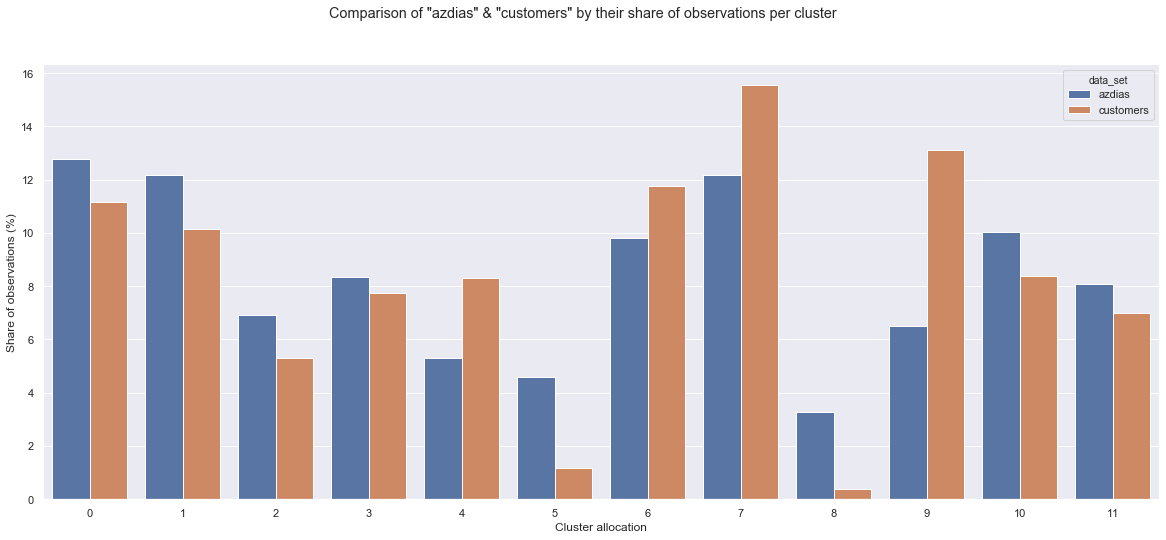

In [95]:
# Plot the distribution of both data sets per cluster

# Prepare the dataset for Barplot visualization
df_t = pd.melt(cls_eval[['cluster', 'rat_azdias', 'rat_customers']].rename({'rat_azdias':'azdias', 'rat_customers':'customers'}, axis=1), id_vars =['cluster']
        , value_vars=['azdias', 'customers'], var_name='data_set', value_name='share_of_total')
df_t['share_of_total'] = df_t['share_of_total'].apply(lambda x: round(x * 100, 2))

sns.set(style='darkgrid')
cfg_figsize = (20, 8)
fig, ax = plt.subplots(figsize=cfg_figsize)
fig.suptitle('Comparison of "azdias" & "customers" by their share of observations per cluster')
ax = sns.barplot(x='cluster', y='share_of_total', hue='data_set', data=df_t, orient='v')
ax.set(xlabel='Cluster allocation', ylabel='Share of observations (%)')
plt.show()

Retrieve the clusters where both data sets have the highest deviations

In [96]:
cls_eval['diff'].abs().sort_values(ascending=False)

9     6.613762
5     3.427346
7     3.376247
4     2.998319
8     2.904175
1     2.049520
6     1.932743
10    1.643459
2     1.612879
0     1.574185
11    1.120199
3     0.589308
Name: diff, dtype: float64

In [98]:
# I take the top 3 deviating clusters for further analysis
sel_cluster = cls_eval['diff'].abs().sort_values(ascending=False).head(5).index.tolist()
print('Clusters to be analyzed:', sel_cluster)

Clusters to be analyzed: [9, 5, 7, 4, 8]


Identify the drivers (features) in these clusters
* PCA comes with feature importance. This allows to identify the most prominent features per cluster. This could be used as input for a classification of the data

### Assemble findings in functions for Pipelinining

#### Preprocessing Pipeline

In [109]:
def cluster_apply(df, pca_n_comp, kmeans_n_cluster):
    '''
    INPUT:
    df - (Pandas DataFrame) The prepared (imputed, scaled) Pandas DataFrame
    pca_n_comp - (int) number of principle components
    kmeans_n_cluster - (int) NUmber of kmeans clusters
    
    OUTPUT:
    df_kmeans - (Pandas DataFrame) Results of K-Means incl. Cluster allocation
    '''
    df = df.copy()
    if ('LNR' in df.columns.tolist()):
        #print('LNR found in DataFrame...')
        lnr = df['LNR'].tolist()
        df.drop(['LNR'], axis=1, inplace=True)
    else:
        lnr = []
        
    # Apply PCA
    print('\t>> [cluster_apply] - executing PCA with {} components...'.format(pca_n_comp))
    pca = PCA(n_components=pca_n_comp)
    pca.fit(df)
    df_pca = pd.DataFrame(pca.transform(df))
    
    
    # Apply K-Means as loaded model
    print('\t>> [cluster_apply] - predicting saved K-means model with {} clusters...'.format(kmeans_n_cluster))
    filename_model = 'model_kmeans.pkl'
    model_import = pickle.load(open(filename_model, 'rb'))
    df_cls = pd.DataFrame(model_import.predict(df_pca), columns=['cluster'])
#     kmeans = KMeans(n_clusters=kmeans_n_cluster, random_state=42)
#     model_kmeans = kmeans.fit(df_pca)
#     df_cls = pd.DataFrame(model_kmeans.predict(df_pca), columns=['cluster'])

    return pd.concat([pd.DataFrame(lnr, columns=['LNR']), df_cls], axis=1)

In [110]:
def preproc_data(df, desc_azdias, n_pca, n_cluster, training_mode=False):
    df = df.copy()
    # Replace "unknown" values with "NaN" by using mapping of the feature (column) description file
    # for index, row in desc_azdias[desc_azdias['Meaning'].str.lower().str.contains('unknown')][['Attribute','Value']].iterrows():
    for index, row in desc_azdias[~desc_azdias['Unknown_Indicator'].isnull()][['Attribute','Unknown_Indicator']].iterrows():
        if row['Attribute'] in df.columns.tolist():

            c_row_dtype = df[row['Attribute']].dtype # store dtype temporarily
            c_replace_dict = {}

            #azdias_nan[row['Attribute']] = azdias_nan[row['Attribute']].astype(str) # Cast to string

            for val in str(row['Unknown_Indicator']).split(','):
                if (c_row_dtype != 'object'):
                    val = int(val)

                c_replace_dict.update({val: np.nan}) # build up the dict for replacement

            df[row['Attribute']].replace(c_replace_dict, inplace=True) # replace the values by nan to recieve the correct missings

            #azdias[row['Attribute']] = azdias[row['Attribute']].astype(c_row_dtype) # Convert dtype back to original one!


    # remove those features with high unique values
    print('shapes before column removal:')
    print('\t',df.shape)

    # Remove high dimensionality columns
    df.drop(['EINGEFUEGT_AM'], axis=1, inplace=True)
    
    # Drop exclusive columns from "customers" data set
    cols_to_drop = ['ONLINE_PURCHASE', 'PRODUCT_GROUP', 'CUSTOMER_GROUP']
    for col in cols_to_drop:
        if col in df.columns.tolist():
            df.drop([col], axis=1, inplace=True)

    print('shapes after column removal:')
    print('\t', df.shape)


    # re-encoding for "CAMEO_DEU_2015". This is a categorical, but ordered variable
    values = ['1A', '1B', '1C', '1D', '1E', '2A', '2B', '2C', '2D', '3A', '3B', '3C', '3D', '4A', '4B', '4C', '4D', '4E', '5A', '5B', '5C', '5D', '5E', '5F', '6A', '6B', '6C', '6D', '6E', '6F', '7A', '7B', '7C', '7D', '7E', '8A', '8B', '8C', '8D', '9A', '9B', '9C', '9D', '9E']
    replace_dict = {}
    for i, val in enumerate(values):
        replace_dict.update({val: i+1})
    replace_dict.update({'XX': None})

    # Apply on both data sets
    df['CAMEO_DEU_2015'].replace(replace_dict, inplace=True)


    # re-encoding for "CAMEO_INTL_2015". This is a categorical, but ordered variable
    values = ['11', '12', '13', '14', '15', '21', '22', '23', '24', '25', '31', '32', '33', '34', '35', '41', '42', '43', '44', '45', '51', '52', '53', '54', '55']
    replace_dict = {}
    for i, val in enumerate(values):
        replace_dict.update({val: i+1})
    replace_dict.update({'XX': None})

    # Apply on both data sets
    df['CAMEO_INTL_2015'] = df['CAMEO_INTL_2015'].apply(lambda x: str(x).strip('.0')) # cast to string, remove tailing ".0"

    df['CAMEO_INTL_2015'] = df['CAMEO_INTL_2015'].map(replace_dict)
    
    # re-encoding for "CAMEO_DEUG_2015". This is a categorical, but ordered variable
    replace_dict = {}
    replace_dict.update({'X': None})

    # Apply on both data sets
    df['CAMEO_DEUG_2015'] = df['CAMEO_DEUG_2015'].apply(lambda x: str(x).strip('.0'))

    df['CAMEO_DEUG_2015'] = df['CAMEO_DEUG_2015'].map(replace_dict)


    # All categories will be encoded by numerics
    df = pd.get_dummies(df)


    # Remove highly correlated columns
    cols_to_drop = ['ANZ_STATISTISCHE_HAUSHALTE', 'CJT_TYP_2', 'CJT_TYP_4', 'CJT_TYP_5', 'D19_BANKEN_ANZ_24', 'D19_BANKEN_DATUM', 'D19_BANKEN_ONLINE_DATUM', 'D19_BANKEN_ONLINE_QUOTE_12', 'D19_GESAMT_ANZ_24', 'D19_GESAMT_DATUM', 'D19_GESAMT_ONLINE_DATUM', 'D19_GESAMT_ONLINE_QUOTE_12', 'D19_KONSUMTYP', 'D19_KONSUMTYP_MAX', 'D19_TELKO_ANZ_24', 'D19_TELKO_DATUM', 'D19_VERSAND_ANZ_12', 'D19_VERSAND_ANZ_24', 'D19_VERSAND_DATUM', 'D19_VERSAND_OFFLINE_DATUM', 'D19_VERSAND_ONLINE_DATUM', 'D19_VERSAND_ONLINE_QUOTE_12', 'D19_VERSI_ANZ_24', 'D19_VERSI_DATUM', 'D19_VERSI_ONLINE_QUOTE_12', 'FINANZ_SPARER', 'FINANZ_VORSORGER', 'GEBAEUDETYP_RASTER', 'GEMEINDETYP', 'KBA05_KRSAQUOT', 'KBA05_KRSHERST1', 'KBA05_KRSHERST2', 'KBA05_KRSHERST3', 'KBA05_KRSKLEIN', 'KBA05_KW1', 'KBA05_KW3', 'KBA05_MOD1', 'KBA05_MOD8', 'KBA05_MOTOR', 'KBA05_SEG1', 'KBA05_SEG10', 'KBA05_SEG2', 'KBA05_SEG4', 'KBA05_SEG5', 'KBA05_SEG6', 'KBA05_SEG7', 'KBA05_SEG8', 'KBA05_SEG9', 'KBA05_ZUL4', 'KBA13_ANTG3', 'KBA13_BAUMAX', 'KBA13_HALTER_25', 'KBA13_HALTER_30', 'KBA13_HALTER_40', 'KBA13_HALTER_50', 'KBA13_HALTER_55', 'KBA13_HALTER_66', 'KBA13_HERST_SONST', 'KBA13_KMH_140', 'KBA13_KMH_250', 'KBA13_KW_30', 'KBA13_MERCEDES', 'KBA13_SEG_KLEINWAGEN', 'KBA13_SEG_VAN', 'KBA13_SITZE_5', 'KBA13_VORB_1', 'KBA13_VORB_2', 'KBA13_VW', 'KK_KUNDENTYP', 'KONSUMZELLE', 'LP_FAMILIE_FEIN', 'LP_FAMILIE_GROB', 'LP_LEBENSPHASE_FEIN', 'LP_LEBENSPHASE_GROB', 'LP_STATUS_GROB', 'MOBI_REGIO', 'ORTSGR_KLS9', 'PLZ8_ANTG1', 'PLZ8_ANTG2', 'PLZ8_ANTG3', 'PLZ8_ANTG4', 'PLZ8_BAUMAX', 'PLZ8_GBZ', 'PLZ8_HHZ', 'PRAEGENDE_JUGENDJAHRE', 'REGIOTYP', 'SEMIO_KAEM', 'SEMIO_VERT', 'STRUKTURTYP', 'VERS_TYP', 'VK_DHT4A', 'VK_DISTANZ', 'VK_ZG11', 'WOHNDAUER_2008', 'ANREDE_KZ']
    # Drop highly correlated features
    df.drop(df[cols_to_drop], axis=1, inplace=True)


    # Missing Value imputation
    # Imputing feature "ALTER_KIND4" & "ALTER_KIND3"
    df = missing_imputation_kind4(df)
    df = missing_imputation_kind3(df)

    # Missing Value imputation per observation (row)
    if (training_mode == True):
        threshold = 0.5 # All observations which contain more than 30% missing columns will be removed from both data sets
        df_t = df.isnull().mean(axis=1).reset_index(name='missing_ratio')#.sort_values(by='missing_ratio', ascending=False)
        print('Removing {} ({}%) rows from data set.'.format(df_t[df_t['missing_ratio'] > threshold].shape[0], round(df_t[df_t['missing_ratio'] > threshold].shape[0] / df.shape[0] * 100, 2)))
        df = df[~df.index.isin(df_t[df_t['missing_ratio'] > threshold].index.tolist())].copy()
        print('DF:', df.shape)


    # Missing Value Imputation on feature (columns)
    # Initiate SimpleImputer, using different strategies

    imp_const = SimpleImputer(missing_values=np.nan, strategy='constant', fill_value=0)
    imp_mostfreq = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
    imp_mean = SimpleImputer(missing_values=np.nan, strategy='mean')

    # Fit & transform data sets
    df_imp = pd.DataFrame(imp_const.fit_transform(df), columns=df.columns) # Apply constant NA-replacement strategy
    #df_imp = pd.DataFrame(imp_mostfreq.fit_transform(df), columns=df.columns) # Apply most frequent NA-replacement strategy
    #df_imp = pd.DataFrame(imp_mean.fit_transform(df), columns=df.columns) # Apply mean NA-replacement strategy
    df = df_imp.copy() # reduce memory consumption
    del df_imp

    # Outlier Detection & Removal
    if (training_mode == True):
        print('[before outlier removal] Data set shapes:')
        print('\tdf: ', df.shape)
        threshold = 8

        # handle azdias DF
        z = np.abs(stats.zscore(df))
        df = df[(z < threshold).all(axis=1)]

        print('[after outlier removal] Data set shapes:')
        print('\tdf: ', df.shape)

        
    # Adding Cluster information to DF
    print('Adding cluster allocation to DF...')
    df_cls = cluster_apply(df, pca_n_comp=n_pca, kmeans_n_cluster=n_cluster)
    df = df.merge(df_cls, on=['LNR'], how='left').fillna(0)
    
    
    # Normalization
    # Applying StandardScaler of scikit-learn package
    scl = StandardScaler()
    df[[x for x in df.columns.tolist() if 'LNR' not in x]] = scl.fit_transform(df.drop(['LNR'], axis=1)) # scale all columns, except the "ID" column
        
    return df

In [108]:
# Testing the pipeline for preprocessing on "azdias" df
azdias_preproc = preproc_data(azdias, desc_azdias, n_pca=122, n_cluster=14, training_mode=True)

shapes before column removal:
	 (891221, 366)
shapes after column removal:
	 (891221, 365)
>> Starting imputation logic for feature "ALTER_KIND4" on dataframe
	before imputation, there are 129 missing observations.
	after imputation, there are 5 missing observations remaining.
>> Starting imputation logic for feature "ALTER_KIND3" on dataframe
	before imputation, there are 583 missing observations.
	after imputation, there are 38 missing observations remaining.
Removing 93953 (10.54%) rows from data set.
DF: (797268, 304)
[before outlier removal] Data set shapes:
	df:  (797268, 304)
[after outlier removal] Data set shapes:
	df:  (656358, 304)
Adding cluster allocation to DF...


In [112]:
customers_preproc = preproc_data(customers, desc_azdias, n_pca=122, n_cluster=14, training_mode=True)
del customers_preproc

shapes before column removal:
	 (191652, 369)
shapes after column removal:
	 (191652, 365)
>> Starting imputation logic for feature "ALTER_KIND4" on dataframe
	before imputation, there are 25 missing observations.
	after imputation, there are 1 missing observations remaining.
>> Starting imputation logic for feature "ALTER_KIND3" on dataframe
	before imputation, there are 105 missing observations.
	after imputation, there are 8 missing observations remaining.
Removing 49985 (26.08%) rows from data set.
DF: (141667, 304)
[before outlier removal] Data set shapes:
	df:  (141667, 304)
[after outlier removal] Data set shapes:
	df:  (118448, 304)
Adding cluster allocation to DF...
	>> [cluster_apply] - executing PCA with 122 components...
	>> [cluster_apply] - predicting saved K-means model with 14 clusters...


## Part 2: Supervised Learning Model

Now that you've found which parts of the population are more likely to be customers of the mail-order company, it's time to build a prediction model. Each of the rows in the "MAILOUT" data files represents an individual that was targeted for a mailout campaign. Ideally, we should be able to use the demographic information from each individual to decide whether or not it will be worth it to include that person in the campaign.

The "MAILOUT" data has been split into two approximately equal parts, each with almost 43 000 data rows. In this part, you can verify your model with the "TRAIN" partition, which includes a column, "RESPONSE", that states whether or not a person became a customer of the company following the campaign. In the next part, you'll need to create predictions on the "TEST" partition, where the "RESPONSE" column has been withheld.

In [115]:
# mailout_train = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_MAILOUT_052018_TRAIN.csv', sep=';') # data path on Udacity workspace environment
mailout_train = pd.read_csv('arvato_data/Udacity_MAILOUT_052018_TRAIN.csv', sep=';') # data path on local workspace environment

C:\Users\spam\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3072: DtypeWarning: Columns (18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [116]:
# Check balance
mailout_train.groupby(['RESPONSE']).agg({'LNR':'count'})

,LNR
RESPONSE,
0,42430
1,532


In [117]:
# Allocate feature & label columns
col_label = 'RESPONSE'


X = mailout_train.drop([col_label], axis=1)
y = mailout_train[col_label]

# Apply preprocessing pipeline
#X_preproc = preproc_data(X, desc_azdias, n_pca=117, n_cluster=14, training_mode=True)
X_preproc = preproc_data(X, desc_azdias, n_pca=122, n_cluster=14, training_mode=True)

# take only those ys which correspond to the Xs
lnrs = X_preproc['LNR'].astype(int).tolist()
y = mailout_train[mailout_train['LNR'].astype(int).isin(lnrs)][col_label]

shapes before column removal:
	 (42962, 366)
shapes after column removal:
	 (42962, 365)
>> Starting imputation logic for feature "ALTER_KIND4" on dataframe
	before imputation, there are 4 missing observations.
	after imputation, there are 1 missing observations remaining.
>> Starting imputation logic for feature "ALTER_KIND3" on dataframe
	before imputation, there are 17 missing observations.
	after imputation, there are 2 missing observations remaining.
Removing 7783 (18.12%) rows from data set.
DF: (35179, 304)
[before outlier removal] Data set shapes:
	df:  (35179, 304)
[after outlier removal] Data set shapes:
	df:  (29132, 304)
Adding cluster allocation to DF...
	>> [cluster_apply] - executing PCA with 122 components...
	>> [cluster_apply] - predicting saved K-means model with 14 clusters...


In [123]:
# Split train & test data by 0.33 ratio for the hold out set; Due to imbalanced datasat, use stratified sampling(!)
X_train, X_test, y_train, y_test = train_test_split(X_preproc.drop(['LNR'], axis=1), y, test_size=0.33, stratify=y ,random_state=42)

In [124]:
# Investigating the spread
df_t = pd.DataFrame(y).reset_index().groupby('RESPONSE').agg({'index':'count'}).reset_index().rename({'index':'cnt_preproc'}, axis=1).merge(\
    mailout_train.groupby('RESPONSE').agg({'LNR':'count'}).reset_index().rename({'LNR':'cnt_orig'}, axis=1)
    , on=['RESPONSE']
    , how='inner')

df_t['rat_preproc'] = round(df_t['cnt_preproc'] / df_t['cnt_preproc'].sum() * 100, 2)
df_t['rat_orig'] = round(df_t['cnt_orig'] / df_t['cnt_orig'].sum() * 100, 2)
df_t

,RESPONSE,cnt_preproc,cnt_orig,rat_preproc,rat_orig
0,0,28773,42430,98.77,98.76
1,1,359,532,1.23,1.24


#### Using h2o to run model

In [126]:
# Merge to df_train & df_test data sets for h2o model process
df_train = pd.concat([X_train.reset_index().drop(['index'], axis=1), pd.DataFrame(y_train).reset_index().drop(['index'], axis=1)], axis=1)
df_test = pd.concat([X_test.reset_index().drop(['index'], axis=1), pd.DataFrame(y_test).reset_index().drop(['index'], axis=1)], axis=1)
print(df_train.shape)
print(df_test.shape)

(19518, 305)
(9614, 305)


In [128]:
import h2o
#h2o.init(nthread=-1, max_mem_size=20)
h2o.init()

Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.251-b08, mixed mode)
  Starting server from C:\Users\spam\Anaconda3\lib\site-packages\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\spam\AppData\Local\Temp\tmp0zoakzlc
  JVM stdout: C:\Users\spam\AppData\Local\Temp\tmp0zoakzlc\h2o_spam_started_from_python.out
  JVM stderr: C:\Users\spam\AppData\Local\Temp\tmp0zoakzlc\h2o_spam_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,02 secs
H2O_cluster_timezone:,Europe/Berlin
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.30.0.7
H2O_cluster_version_age:,12 days
H2O_cluster_name:,H2O_from_python_spam_rd2kid
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,5.320 Gb
H2O_cluster_total_cores:,8
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"accepting new members, healthy"


In [129]:
# Import data
data_train = h2o.H2OFrame(df_train)
data_test = h2o.H2OFrame(df_test)

Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%


In [130]:
# Encode target / response variable as factor
data_train['RESPONSE'] = data_train['RESPONSE'].asfactor()
data_test['RESPONSE'] = data_test['RESPONSE'].asfactor()

In [131]:
# Identify feature and response variables
y_label = 'RESPONSE'
x_feat = list(data_train.columns)
x_feat.remove(y_label)

**h2o Auto-ML**

In [133]:
from h2o.automl import H2OAutoML
# Config
cfg_max_models = 10
cfg_seed = 1

In [134]:
aml = H2OAutoML(max_models = cfg_max_models, seed = cfg_seed, balance_classes=False)
aml.train(x=x_feat, y=y_label, training_frame=data_train)

AutoML progress: |
07:40:26.119: AutoML: XGBoost is not available; skipping it.

████████████████████████████████████████████████████████| 100%


In [135]:
lb = aml.leaderboard
lb.head()

model_id,auc,logloss,aucpr,mean_per_class_error,rmse,mse
GBM_grid__1_AutoML_20200803_074026_model_1,0.790684,0.0603203,0.0382255,0.434365,0.110388,0.0121855
GBM_3_AutoML_20200803_074026,0.790469,0.0667808,0.0355795,0.357971,0.111305,0.0123889
GBM_2_AutoML_20200803_074026,0.787389,0.0651257,0.0401814,0.321614,0.112861,0.0127375
GBM_1_AutoML_20200803_074026,0.779767,0.0748404,0.0360305,0.344511,0.124574,0.0155186
GBM_4_AutoML_20200803_074026,0.765202,0.0701483,0.0346435,0.449561,0.111638,0.0124631
GBM_5_AutoML_20200803_074026,0.753326,0.0638317,0.0332239,0.40846,0.110354,0.0121781
StackedEnsemble_AllModels_AutoML_20200803_074026,0.738717,0.0644187,0.0312066,0.41292,0.111181,0.0123613
StackedEnsemble_BestOfFamily_AutoML_20200803_074026,0.706712,0.0645462,0.0280987,0.430165,0.110724,0.0122598
GLM_1_AutoML_20200803_074026,0.641121,0.0651121,0.0205092,0.434579,0.110274,0.0121605
XRT_1_AutoML_20200803_074026,0.59582,0.173116,0.0187435,0.451432,0.111605,0.0124558


In [136]:
# Evaluatemodel_performanceformance on separated test set
perf_testdata = aml.leader.model_performance(data_test)

In [137]:
perf_testdata.confusion_matrix() # no balance (original distribution)


Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.025868164106163792: 


,,0,1,Error,Rate
0,0,8408.0,1088.0,0.1146,(1088.0/9496.0)
1,1,70.0,48.0,0.5932,(70.0/118.0)
2,Total,8478.0,1136.0,0.1204,(1158.0/9614.0)


In [141]:
# Calculate precision & recall
perf_precision = perf_testdata.confusion_matrix().to_list()[1][1] / (perf_testdata.confusion_matrix().to_list()[1][1] + perf_testdata.confusion_matrix().to_list()[0][1])
perf_recall = perf_testdata.confusion_matrix().to_list()[1][1] / (perf_testdata.confusion_matrix().to_list()[1][1] + perf_testdata.confusion_matrix().to_list()[1][0])
print('Precision:{:>7}'.format(np.round(perf_precision, 4)))
print('Recall:{:>10}'.format(np.round(perf_recall, 4)))
print('F1-score:{:>8}'.format(np.round(perf_testdata.F1()[0][1], 4)))
print('AUC:{:>8}'.format(np.round(perf_testdata.auc(), 4)))

Precision: 0.0423
Recall:    0.4068
F1-score:  0.0766
AUC:  0.7772


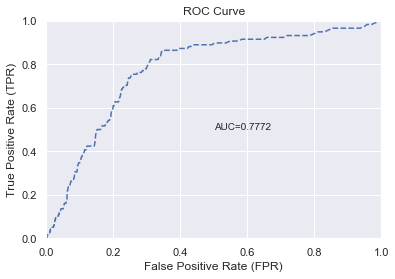

In [139]:
# Plotting ROC Curve
perf_testdata.plot()

In [140]:
# Cumulative Lift Gain
perf_testdata.gains_lift()


Gains/Lift Table: Avg response rate:  1,23 %, avg score:  1,18 %


,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain,kolmogorov_smirnov
0,1,0.010089,0.083092,2.519832,2.519832,0.030928,0.158883,0.030928,0.158883,0.025424,0.025424,151.983226,151.983226,0.015525
1,2,0.020075,0.058436,2.546081,2.532888,0.031250,0.067311,0.031088,0.113334,0.025424,0.050847,154.608051,153.288838,0.031155
2,3,0.030060,0.047241,5.092161,3.383027,0.062500,0.051999,0.041522,0.092960,0.050847,0.101695,409.216102,238.302739,0.072525
3,4,0.040046,0.042106,1.697387,2.962712,0.020833,0.044299,0.036364,0.080826,0.016949,0.118644,69.738701,196.271186,0.079575
4,5,0.050031,0.038284,1.697387,2.710173,0.020833,0.040031,0.033264,0.072684,0.016949,0.135593,69.738701,171.017302,0.086625
5,6,0.100062,0.028082,4.234645,3.472409,0.051975,0.032313,0.042620,0.052499,0.211864,0.347458,323.464534,247.240918,0.250469
6,7,0.149990,0.022622,2.206603,3.051059,0.027083,0.025202,0.037448,0.043412,0.110169,0.457627,120.660311,205.105903,0.311460
7,8,0.200021,0.018662,2.540787,2.923425,0.031185,0.020656,0.035881,0.037720,0.127119,0.584746,154.078720,192.342473,0.389506
8,9,0.299979,0.010945,1.865183,2.570800,0.022893,0.014761,0.031553,0.030070,0.186441,0.771186,86.518281,157.079974,0.477063
9,10,0.400042,0.005919,1.016315,2.181976,0.012474,0.007892,0.026781,0.024522,0.101695,0.872881,1.631488,118.197643,0.478715


In [142]:
# Variable Importance of best, compatible model (this could be XGB, GMB)
searchfor = ['xgb', 'gbm']
model_index = aml.leaderboard.as_data_frame()[aml.leaderboard.as_data_frame()['model_id'].str.lower().str.contains('|'.join(searchfor))].index[0]
model = h2o.get_model(aml.leaderboard.as_data_frame()['model_id'][model_index])
print('Best compatible model for variable importance is\n\trank: {0} with\n\tID: {1}'.format(model_index, model.model_id))
model_varimp = model.varimp(use_pandas=True)
model_varimp.head(50)

Best compatible model for variable importance is
	rank: 0 with
	ID: GBM_grid__1_AutoML_20200803_074026_model_1


,variable,relative_importance,scaled_importance,percentage
0,D19_SOZIALES,18.234421,1.000000,0.178735
1,ANZ_HAUSHALTE_AKTIV,4.296572,0.235630,0.042115
2,CAMEO_DEU_2015,3.101165,0.170072,0.030398
3,KBA13_ANZAHL_PKW,2.869345,0.157359,0.028126
4,EXTSEL992,2.370069,0.129978,0.023232
5,CJT_GESAMTTYP,2.061346,0.113047,0.020205
6,MIN_GEBAEUDEJAHR,1.876948,0.102934,0.018398
7,KBA05_VORB2,1.822726,0.099961,0.017867
8,ANZ_HH_TITEL,1.808617,0.099187,0.017728
9,SEMIO_RAT,1.523937,0.083575,0.014938


In [143]:
# Store model to disk
t_filePath = 'model_h2o_automl_leader'
model_path = h2o.save_model(model=aml.leader, path=t_filePath, force=True)
print('h2o model stored in:\n\t', t_filePath)

# Store Mojo model to disk
aml.leader.download_mojo(path=t_filePath, get_genmodel_jar=True)

# Store DataFrame layout to disk
t_filePath = 'dataset_layout.csv'
pd.DataFrame.from_dict(data=data_train.types, orient='index').reset_index().rename({'index':'attribute_name', 0:'data_type'}, axis=1).to_csv(t_filePath, sep='|', index=False)
print('writing meta description file to:\n\t', t_filePath)

h2o model stored in:
	 model_h2o_automl_leader
writing meta description file to:
	 dataset_layout.csv


Retrieve model parameters

In [144]:
model01 = h2o.get_model(aml.leaderboard.as_data_frame()['model_id'][0])
model01.actual_params

{'model_id': 'GBM_grid__1_AutoML_20200803_074026_model_1',
 'training_frame': 'automl_training_py_1_sid_abe9',
 'validation_frame': None,
 'nfolds': 5,
 'keep_cross_validation_models': False,
 'keep_cross_validation_predictions': True,
 'keep_cross_validation_fold_assignment': False,
 'score_each_iteration': False,
 'score_tree_interval': 5,
 'fold_assignment': 'Modulo',
 'fold_column': None,
 'response_column': 'RESPONSE',
 'ignored_columns': [],
 'ignore_const_cols': True,
 'offset_column': None,
 'weights_column': None,
 'balance_classes': False,
 'class_sampling_factors': None,
 'max_after_balance_size': 5.0,
 'max_confusion_matrix_size': 20,
 'max_hit_ratio_k': 0,
 'ntrees': 37,
 'max_depth': 4,
 'min_rows': 5.0,
 'nbins': 20,
 'nbins_top_level': 1024,
 'nbins_cats': 1024,
 'r2_stopping': 1.7976931348623157e+308,
 'stopping_rounds': 0,
 'stopping_metric': 'logloss',
 'stopping_tolerance': 0.007157845881240827,
 'max_runtime_secs': 0.0,
 'seed': 2,
 'build_tree_one_node': False,
 '

#### GridSearchCV
* h2o Auto-ML came up with a GBM. Let's use this in scikit-learn along with a parameter grid search

In [ ]:
# Initiate GBM
clf = GradientBoostingClassifier(random_state=42)

# Parameters for grid search
parameters = {
    "loss":["deviance"],
    "learning_rate": [0.05, 0.1, 0.2],
    #"min_samples_split": np.linspace(0.1, 0.5, 12),
    "min_samples_leaf": np.linspace(0.1, 0.5, 12),
    "max_depth":[6,8,10],
    #"max_features":["log2","sqrt"],
    #"criterion": ["friedman_mse",  "mae"],
    "subsample":[0.5, 0.8, 0.9, 1.0],
    "n_estimators":[10]
    }

cv = GridSearchCV(estimator=clf, param_grid=parameters, cv=10, n_jobs=-1)

cv.fit(X_train, y_train)

model = cv.best_estimator_

preds = model.predict(X_test)

print(cv.score(X_train, y_train))
print(cv.best_params_)

preds = cv.predict(X_test)

In [ ]:
# Evaluate model on test data set
print('Accuracy: ', round(accuracy_score(y_test, preds), 4))
#print('Precision: ', round(precision_score(y_test, preds), 4))
print('Recall: ', round(recall_score(y_test, preds), 4))
print('F1-Score: ', round(f1_score(y_test, preds), 4))


#precision_score, recall_score, f1_score, roc_auc_score

In [ ]:
pd.DataFrame(preds, columns=['RESPONSE_pred']).reset_index().groupby(['RESPONSE_pred']).agg({'index':'count'})

**Comment:**
* Transferring the learned parameters from h2o auto-ml to scikit-learn didn't worked. As shown, the model predicts all observations of the test data set as "0". This might be an issue due to the imbalanced classes, but is not acceptable. --> Therefore, I'll use the h2o model to predict the data set for Kaggle.
* Ideas for improvement:
 * Check the or elude the removal of observations w/ "RESPONSE=1", even, if they contain many missings.
 * re-calibrate the parameters for the GridSearchCV
 * use other estimators - 
  * RandomForest (... but my experience shows, that GBM outperforms RND)
  * other Boosting algos like _Adaboost_ or _XGBoost_
 * Apply balancing method (undersampling or oversamling like SMOTE) before fitting GridSearchCV

## Part 3: Kaggle Competition

Now that you've created a model to predict which individuals are most likely to respond to a mailout campaign, it's time to test that model in competition through Kaggle. If you click on the link [here](http://www.kaggle.com/t/21e6d45d4c574c7fa2d868f0e8c83140), you'll be taken to the competition page where, if you have a Kaggle account, you can enter. If you're one of the top performers, you may have the chance to be contacted by a hiring manager from Arvato or Bertelsmann for an interview!

Your entry to the competition should be a CSV file with two columns. The first column should be a copy of "LNR", which acts as an ID number for each individual in the "TEST" partition. The second column, "RESPONSE", should be some measure of how likely each individual became a customer – this might not be a straightforward probability. As you should have found in Part 2, there is a large output class imbalance, where most individuals did not respond to the mailout. Thus, predicting individual classes and using accuracy does not seem to be an appropriate performance evaluation method. Instead, the competition will be using AUC to evaluate performance. The exact values of the "RESPONSE" column do not matter as much: only that the higher values try to capture as many of the actual customers as possible, early in the ROC curve sweep.

In [ ]:
# Starting h2o cluster
h2o.init()

In [145]:
model_import = h2o.load_model('model_h2o_automl_leader/GBM_grid__1_AutoML_20200803_074026_model_1')

In [146]:
#mailout_test = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_MAILOUT_052018_TEST.csv', sep=';')
mailout_test = pd.read_csv('arvato_data/Udacity_MAILOUT_052018_TEST.csv', sep=';')

C:\Users\spam\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3072: DtypeWarning: Columns (18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [147]:
mailout_test.head()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,1754,2,1.0,7.0,NaN,NaN,NaN,NaN,6.0,2.0,...,4.0,5.0,6.0,3.0,6.0,9.0,3.0,3,1,4
1,1770,-1,1.0,0.0,NaN,NaN,NaN,NaN,0.0,20.0,...,1.0,5.0,2.0,1.0,6.0,9.0,5.0,3,1,4
2,1465,2,9.0,16.0,NaN,NaN,NaN,NaN,11.0,2.0,...,3.0,9.0,6.0,3.0,2.0,9.0,4.0,3,2,4
3,1470,-1,7.0,0.0,NaN,NaN,NaN,NaN,0.0,1.0,...,2.0,6.0,6.0,3.0,NaN,9.0,2.0,3,2,4
4,1478,1,1.0,21.0,NaN,NaN,NaN,NaN,13.0,1.0,...,1.0,2.0,4.0,3.0,3.0,9.0,7.0,4,2,4


In [150]:
# Apply preprocessing pipeline
mailout_test_preproc = preproc_data(mailout_test, desc_azdias, n_pca=122, n_cluster=14, training_mode=False)

shapes before column removal:
	 (42833, 366)
shapes after column removal:
	 (42833, 365)
>> Starting imputation logic for feature "ALTER_KIND4" on dataframe
	before imputation, there are 2 missing observations.
	after imputation, there are 0 missing observations remaining.
>> Starting imputation logic for feature "ALTER_KIND3" on dataframe
	before imputation, there are 15 missing observations.
	after imputation, there are 1 missing observations remaining.
Adding cluster allocation to DF...
	>> [cluster_apply] - executing PCA with 122 components...
	>> [cluster_apply] - predicting saved K-means model with 14 clusters...


In [151]:
h2o_mailout_test = h2o.H2OFrame(mailout_test_preproc)

Parse progress: |█████████████████████████████████████████████████████████| 100%


In [152]:
preds_mailout_test = model_import.predict(h2o_mailout_test)

gbm prediction progress: |████████████████████████████████████████████████| 100%


In [153]:
df_preds_mailout_test = preds_mailout_test.as_data_frame()
df_preds_mailout_test.groupby('predict').agg({'p0':'count'})

,p0
predict,
0,42726
1,107


Prepare Kaggle submission data set

In [154]:
df_pred_submission = pd.concat([mailout_test['LNR'], df_preds_mailout_test], axis=1)[['LNR', 'p1']].rename({'p1':'RESPONSE'}, axis=1)
df_pred_submission.head()

# Export Kaggle submission file
df_pred_submission.to_csv('pred_submission_v2.csv', index=False)

In [155]:
h2o.shutdown()

C:\Users\spam\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: Deprecated, use ``h2o.cluster().shutdown()``.
  """Entry point for launching an IPython kernel.


H2O session _sid_abe9 closed.
